## 49er fan or Raider fan?

### Problem Statement

Robotics AI creates AI for robots that human's interact with. In order to build a better AI which can infer from context and other clues what text is referring to between two choices, they've tasked us with creating a Natural Lamguage Processing model that can do exactly that with text from two different subreddits.

In this project, we will be taking in the comments and titles from two subreddits: 49ers and Raiders, and creating a model that will try to predict from which subreddit each comment comes from. The goal is to see if we can create a model that can accurately predict the context of a comment without the knowledge of where the comment is coming from, by using natural language processing on the comments. We will be evaluating the model on the accuracy of its predictions and the $r^2$ score of it's features, which measures what percent of the variability in the predictions are explained by the features in the model. 

In this project we will be doing the following steps:

- Scraping data from two subreddits using PushShift API
- Exploring and cleaning the data
- Feature engineering
- Preprocessing the text data for use in our model
 - Tokenizing
 - Sentiment analysis
 - Lemmatizing
- Vectorizing text data
- Modeling including:
 - GridSearchCV
 - Multinomial Naïve Bayes Classifer
 - Decision Tree Classifier
 - ADA Boost Classifier
 - Linear SVC
 - Random Forest Classifier
- Final analysis and conclusion with recommendations

### Data Collection

In [1]:
# !pip install textacy

In [2]:
# !python -m textacy download capitol_words
# !python -m textacy download lang_identifier --version 2.0

In [3]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import (GradientBoostingClassifier,
                              AdaBoostClassifier,
                              VotingClassifier)
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, 
                             recall_score, precision_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import datetime
import time
import re

from textacy import preprocessing

pd.options.display.max_colwidth = 350

In [4]:
# setting url variable as beginning of url
# code help from https://www.youtube.com/watch?v=AcrjEWsMi_E

url = 'https://api.pushshift.io/reddit/search/submission'

In [5]:
# Code help from Catherine Clary

def query_subreddit(subreddit, pulls):

    url = 'https://api.pushshift.io/reddit/search/submission'
    epoch = int(datetime.datetime(2021,10,4,0,0).timestamp())
    each_pull = 100
    total_pulls = pulls
    params = {
        'subreddit': subreddit,
        'size': each_pull,
        'before': epoch,
        'selftext:not': '[removed]',
    }
    
    df_all = []

    for i in range(0, total_pulls, each_pull):
    
        params['before'] = epoch
        print(f'Starting epoch = {epoch}')
        res = requests.get(url, params)
        res.status_code
        data = res.json()
        posts = data['data']

        data_list = []
        for data in posts:
            dictionary = {}
            if 'id' in data:
                dictionary['id'] = data['id']
            if 'subreddit' in data:
                dictionary['subreddit'] = data['subreddit']
            if 'created_utc' in data:
                dictionary['created_utc'] = data['created_utc']
            if ('selftext' in data) and ('selftext' != np.nan) and ('selftext' != '[deleted]'):
                dictionary['comment'] = data['selftext']
            if ('title' in data) and ('title' != np.nan) and ('title' != '[deleted]'):
                dictionary['title'] = data['title']
            if dictionary not in data_list:
                data_list.append(dictionary)
        
        df = pd.DataFrame(data_list, columns=dictionary.keys())
        ending_epoch = df['created_utc'][len(df)-1]
        epoch = int( ending_epoch )
        time.sleep(2)

        print(df.shape)

        df_all.append(df)
        
    df_final = pd.concat(df_all)
    
    return df_final

In [6]:
# using function on '49ers' subreddit

niners_df = query_subreddit('49ers', 500)


Starting epoch = 1633330800
(100, 5)
Starting epoch = 1633237647
(100, 5)
Starting epoch = 1632948228
(100, 5)
Starting epoch = 1632776348
(100, 5)
Starting epoch = 1632682837
(100, 5)


In [7]:
print(len(niners_df))
print(type(niners_df))

500
<class 'pandas.core.frame.DataFrame'>


In [8]:
# checking value counts to see how many unique titles are in the data
niners_df['title'].value_counts()

Rough                                                                                              2
STOP THE COUNT!!                                                                                   2
It's Gameday!!!                                                                                    2
Follow Me Fridays                                                                                  2
They Grow Up So Fast                                                                               2
                                                                                                  ..
Given the recent news about Brady, here’s a fun little thread from after we lost the Super Bowl    1
Autograph Help Needed! (Details in post)                                                           1
My daughter got JaMycal Hasty autograph it was great..... she was so happy                         1
First Time at Home Game                                                                    

In [9]:
# checking value counts to see how many unique titles are in the data
niners_df['comment'].value_counts()

                                                                                                                                                                                                                                                                                                                                                                                  400
[deleted]                                                                                                                                                                                                                                                                                                                                                                           2
Hey everyone! Happy Friday! What's on your mind? Use this thread to discuss anything you like.                                                                                                                                                              

In [10]:
# using function on 'Raiders' subreddit
raiders_df = query_subreddit('Raiders', 500)
raiders_df

Starting epoch = 1633330800
(100, 5)
Starting epoch = 1633141500
(100, 5)
Starting epoch = 1633017522
(100, 5)
Starting epoch = 1632923600
(100, 5)
Starting epoch = 1632794777
(100, 5)


,id,subreddit,created_utc,comment,title
0,q0xjjk,raiders,1633318718,A bunch of misfit toys that everyone thought was washed up but they get the job done their way,Hate me if you want but Tampa Bay reminds me of the 70s Raiders
1,q0xhnu,raiders,1633318509,,Jon Gruden's QB Camp - Jon Gruden Vs Jon Gruden
2,q0x79r,raiders,1633317385,,"Was looking at the all time passing list after Brady broke the record, found out Derek Carr is in 62nd place"
3,q0x0ik,raiders,1633316674,Anyone have any tips for parking and tail gating at SoFi tomorrow. Coming from San Diego so I’m wondering how early I should go and what the best way to find decent priced parking. It’s my first Raider game.,Parking/tailgates at SoFi.
4,q0wuqb,raiders,1633316102,,She's ready for tomorrow's game! RNFL
...,...,...,...,...,...
95,pwg7cd,raiders,1632746435,,"For the haters, bspn, gmfb and everybody else that doesnt recognize, this is for you.."
96,pwfyct,raiders,1632745556,,3-0 baby!!
97,pwftou,raiders,1632745076,"I mean that shit's gonna get our QB injured if he don't step it up, there were multiple plays where he just did not do a good job.",Anyone Worried About Kenyan Drake's Pass Blocking?
98,pwfkrq,raiders,1632744148,"When we conceded a TD and 2 point conversion in the last few seconds , I just knew we would lose. \nWhen we let Dolphins convert 4th and 20 in overtime, I just knew we would lose. \n\nWell - WTF do I know !!! \n\nWhat a performance - we would definitely have lost that last season. \n\nRaiders going 17-0 baby",Watched on redzone in the UK. When Carlson missed the XP to put us 9points clear I just knew we would lose.


In [11]:
# checking value counts to see how many unique titles are in the data
raiders_df['title'].value_counts()

So exicted that the raiders are 3-0!😬 almost had a heart attack lol but a win is a win. RN4L🖤[F]    6
☠️☠️☠️                                                                                              3
Ticket Sale                                                                                         2
Hey Siri, who is the passing leader in the NFL?                                                     2
Casey Hayward Presser                                                                               2
                                                                                                   ..
Have a good week                                                                                    1
Imagine Raiders back in LA for the Super Bowl with this line-up for the halftime show               1
🏴                                                                                                   1
🏴‍☠️👻👻👻🏴‍☠️                                                                       

### Data Cleaning & EDA

In [12]:
# checking info of niners_df for length of columns and null-values
niners_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           500 non-null    object
 1   subreddit    500 non-null    object
 2   created_utc  500 non-null    int64 
 3   comment      499 non-null    object
 4   title        500 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.4+ KB


In [13]:
# checking info of niners_df for length of columns and null-values
raiders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           500 non-null    object
 1   subreddit    500 non-null    object
 2   created_utc  500 non-null    int64 
 3   comment      500 non-null    object
 4   title        500 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.4+ KB


There are some null values in the comments but we will focus on the titles so we'll leave the null as-is for now

In [14]:
# converting all text to string type
niners_df.loc[:,'comment'] = niners_df.loc[:,'comment'].astype(str)
raiders_df.loc[:,'comment'] = raiders_df.loc[:,'comment'].astype(str)

In [15]:
# code from lesson 5.03
# 49ers
# Using sent_tokenize to create new columns of count # of sentances in each title and comment
niners_df['title_sent_count'] = [len(row) for row in niners_df['title'].map(sent_tokenize)]
niners_df['comment_sent_count'] = [len(row) for row in niners_df['comment'].map(sent_tokenize)]

# Using word_tokenize to create new columns of count # of sentances in each title and comment
niners_df['title_word_count'] = [len(row) for row in niners_df['title'].map(word_tokenize)]
niners_df['comment_word_count'] = [len(row) for row in niners_df['comment'].map(word_tokenize)]

In [16]:
# Using sent_tokenize to create new columns of count # of sentances in each title and comment
# Raiders
raiders_df['title_sent_count'] = [len(row) for row in raiders_df['title'].map(sent_tokenize)]
raiders_df['comment_sent_count'] = [len(row) for row in raiders_df['comment'].map(sent_tokenize)]

# Using word_tokenize to create new columns of count # of sentances in each title and comment
raiders_df['title_word_count'] = [len(row) for row in raiders_df['title'].map(word_tokenize)]
raiders_df['comment_word_count'] = [len(row) for row in raiders_df['comment'].map(word_tokenize)]

In [17]:
# sorting values to see highest counts of word lengths
print (niners_df.loc[:, 'comment_sent_count'].sort_values(ascending=False))

4     43
77    28
56    23
13    21
6     19
      ..
86     0
85     0
84     0
83     0
99     0
Name: comment_sent_count, Length: 500, dtype: int64


In [18]:
# sorting values to see highest counts of word lengths
print (niners_df.loc[:, 'comment_word_count'].sort_values(ascending=False))

4     955
13    604
77    539
56    500
53    436
     ... 
86      0
85      0
84      0
83      0
99      0
Name: comment_word_count, Length: 500, dtype: int64


In [19]:
# sorting values to see highest counts of word lengths
print (raiders_df.loc[:, 'comment_sent_count'].sort_values(ascending=False))

51    46
49    38
69    31
83    28
33    23
      ..
1      0
2      0
54     0
53     0
50     0
Name: comment_sent_count, Length: 500, dtype: int64


In [20]:
# sorting values to see highest counts of word lengths
print (raiders_df.loc[:, 'comment_word_count'].sort_values(ascending=False))

51    1088
49     780
33     571
33     492
95     446
      ... 
1        0
49       0
48       0
47       0
50       0
Name: comment_word_count, Length: 500, dtype: int64


In [21]:
# Creating a small df of means of word counts

niners_means = niners_df.agg({
    'title_word_count': 'mean',
    'comment_word_count': 'mean'})

raiders_means = raiders_df.agg({
    'title_word_count': 'mean',
    'comment_word_count': 'mean'})


means = pd.concat([niners_means, raiders_means], axis=1)
means.rename(columns={0:'49ers', 1:'Raiders'})

,49ers,Raiders
title_word_count,19.674,11.436
comment_word_count,19.290,28.660


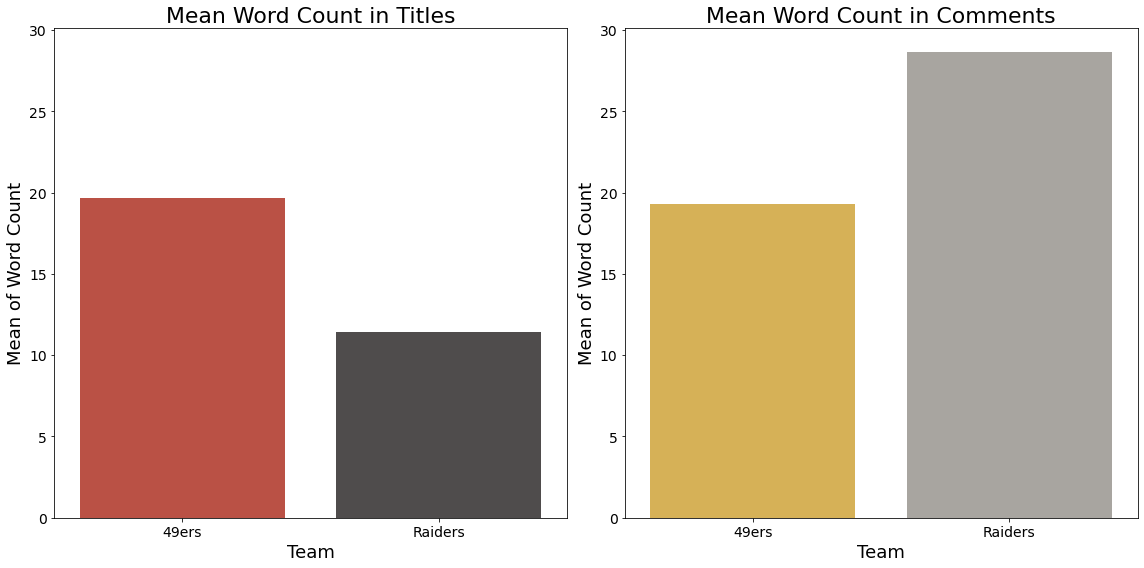

In [22]:
# plotting the above means dfs
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax = plt.subplot(1, 2, 1)
ax = sns.barplot(data=means,
            x=['49ers', 'Raiders'],
            y=means.loc['title_word_count'],
            palette=['#CD4232','#4F4C4C'])    
ax.set_title('Mean Word Count in Titles', size=22)
ax.set_ylabel('Mean of Word Count', size=18)
ax.set_xlabel('Team', size=18)
plt.yticks(size=14)
plt.xticks(size=14)

ax2 = plt.subplot(1, 2, 2, sharey=ax)
ax2 = sns.barplot(data=means,
            x=['49ers', 'Raiders'],
            y=means.loc['comment_word_count'],
            palette=['#EBBA42', '#A9A69F'])         
ax2.set_title('Mean Word Count in Comments', size=22)
ax2.set_ylabel('Mean of Word Count', size=18)
ax2.set_xlabel('Team', size=18)
plt.yticks(size=14)
plt.xticks(size=14)

plt.tight_layout()

plt.savefig('charts/subreddit_word_counts.png', bbox_inches='tight');

#### ** Interpretation **

We can see from the above word counts that there are more words on average in the 'Raiders' comments than the '49ers', but more words on average in the '49ers' titles than 'Raiders' titles. This might help our model in deciding it's predictions, so we will include these columns in our features later.

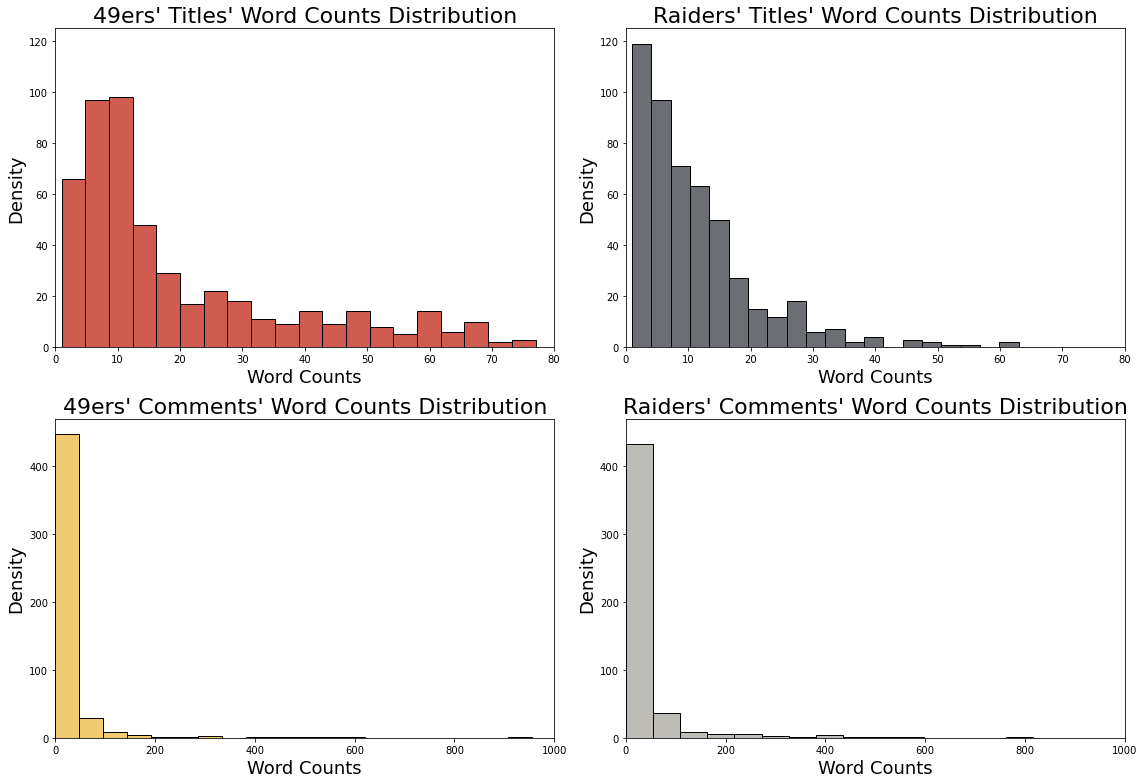

In [23]:
# more visuals to see the distributions of word counts

fig, ax = plt.subplots(5, 1, figsize=(16, 11))
ax = plt.subplot(2, 2, 1)
ax = sns.histplot(data=niners_df, x='title_word_count', bins=20, color='#BF2614')
ax.set_title("49ers' Titles' Word Counts Distribution", size=22)
ax.set_xlabel('Word Counts',size=18)
ax.set_ylabel('Density',size=18)
ax.set_xlim(0, 80)

ax2 = plt.subplot(2, 2, 2, sharey=ax)
ax2 = sns.histplot(data=raiders_df, x='title_word_count', bins=20, color='#3A3F45')
ax2.set_title("Raiders' Titles' Word Counts Distribution", size=22)
ax2.set_xlabel('Word Counts',size=18)
ax2.set_ylabel('Density',size=18)
ax2.set_xlim(0, 80)

ax3 = plt.subplot(2, 2, 3)
ax3 = sns.histplot(data=niners_df, x='comment_word_count', bins=20, color='#EBBA42')
ax3.set_title("49ers' Comments' Word Counts Distribution", size=22)
ax3.set_xlabel('Word Counts',size=18)
ax3.set_ylabel('Density',size=18)
ax3.set_xlim(0, 1000)

ax4 = plt.subplot(2, 2, 4, sharey=ax3)
ax4 = sns.histplot(data=raiders_df, x='comment_word_count', bins=20, color='#A9A69F')
ax4.set_title("Raiders' Comments' Word Counts Distribution", size=22)
ax4.set_xlabel('Word Counts',size=18)
ax4.set_ylabel('Density',size=18)
ax4.set_xlim(0, 1000)

plt.tight_layout()
plt.savefig('charts/subreddit_word_counts_dist.png');

#### ** Interpretation **

The distribution charts above show that our data has a lot more low word counts than high word counts. Given the subjects of the subreddits it's probably a lot of "Go team!"

##### Next...
In order for our data to work with CountVectorizer(), we will need to colapse our 'comment' and 'title' columns into 1 series.


In [24]:
# concatenating titles with their subsequent comments into one series as a new column
niners_df['title_comment'] = (niners_df['comment'] + ' ' + niners_df['title'])

niners_df.isna().sum()

id                    0
subreddit             0
created_utc           0
comment               0
title                 0
title_sent_count      0
comment_sent_count    0
title_word_count      0
comment_word_count    0
title_comment         0
dtype: int64

In [25]:
# dropping all missing values since we only have a few
niners_df.dropna(inplace=True)

niners_df.drop(columns=['comment', 'title'], inplace=True)

In [26]:
# checking our new columns
niners_df.head()

,id,subreddit,created_utc,title_sent_count,comment_sent_count,title_word_count,comment_word_count,title_comment
0,q0yp10,49ers,1633323394,1,4,9,30,What do you guys think will happen? Even if he gets a solid win against a strong Arizona. Could they start jimmy? Tell me your thoughts. What happens if Lance balls out next weekend?
1,q0yp0u,49ers,1633323394,5,0,69,0,"[Inman] #49ers Kyle Shanahan said wasn't anticipating QB switch at halftime until Garoppolo calf too sore to go. And now? ""Trey is there for a reason. Want to give him the time and have him fully ready. But you don’t always have that luxury, and we’ll find that out the next couple days."""
2,q0yiy0,49ers,1633322677,4,0,52,0,"Cameron Salerno: If Kyle Shanahan was a “free agent” coach, he would be off the market within the hour. Does he deserve to be criticized for some decisions? Absolutely. But #49ers fans who think he should be fired right now are just delusional."
3,q0ybkx,49ers,1633321852,1,3,13,93,"I have wrote 2 posts where I explained some points about why Kyle isn't getting some criticism that imo he deserves, I wasn't disrespectful or anything and I'm used to seeing a lot of reddit posts that contain criticism and even insults to the HC (I'm a Dodgers fan and Lakers fan, don't judge me). Why do mods delete those types of posts here? I..."
4,q0y6sg,49ers,1633321297,1,43,8,955,"I'm not trying to go on a rant or seem delusional (mods please don't delete this I wanna have a nice conversation :))))), I've been a huge Kyle fan and have defended him a lot, but his decision making and comments since the end of the 2020 season have been highly questionable in my opinion.\n\nThe 2020 revenge tour ended and it was clear that t..."


In [27]:
# code help from https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html
# code help from https://textacy.readthedocs.io/en/0.11.0/api_reference/preprocessing.html
def clean_text(text):
    
    preprocessing_pipe = preprocessing.make_pipeline(
                         preprocessing.replace.urls,
                         preprocessing.normalize.unicode,
                         preprocessing.remove.accents,
                         preprocessing.replace.emails,
                         preprocessing.replace.user_handles,
                         preprocessing.replace.hashtags,
                         preprocessing.normalize.whitespace,
                         preprocessing.remove.html_tags,
                         preprocessing.remove.brackets)
    
    if (type(text) == 'pandas.core.series.Series') | (type(text) == list):
        for row in text:
            preprocessing_pipe(text)
            
    if type(text) == str:
        preprocessing_pipe(text)
        
    return text

We don't want it to be too easy for our model to predict the different posts so we will make it a little more challenging by remloving the team names (which happen to also be the subreddit names) from the posts.

In [28]:
# cleaning out team names from text in order to make it more difficult for the model to tell the posts apart

niners_df['title_comment'] = clean_text(niners_df['title_comment'])

niners_df.replace(r'\\n', '',inplace=True, regex=True)
niners_df['title_comment'].replace(r'(49ers?)', 'team', inplace=True, regex=True)
niners_df['title_comment'].replace(r'([Nn]iners?)', 'team', inplace=True, regex=True)
niners_df['title_comment'].replace(r'(\[deleted\])', 'team', inplace=True, regex=True)
niners_df['title_comment']

0                                                                                                                                                                            What do you guys think will happen? Even if he gets a solid win against a strong Arizona. Could they start jimmy? Tell me your thoughts. What happens if Lance balls out next weekend?
1                                                                   [Inman] #team Kyle Shanahan said wasn't anticipating QB switch at halftime until Garoppolo calf too sore to go. And now? "Trey is there for a reason. Want to give him the time and have him fully ready. But you don’t always have that luxury, and we’ll find that out the next couple days."
2                                                                                                               Cameron Salerno: If Kyle Shanahan was a “free agent” coach, he would be off the market within the hour. Does he deserve to be criticized for some decisions? Absolutely. But #te

In [29]:
# we need to do the same thing for both dataframes in order to make sure are classes and our features are on equal footing
raiders_df['title_comment'] = (raiders_df['comment'] + ' ' + raiders_df['title'])
raiders_df.isna().sum()

id                    0
subreddit             0
created_utc           0
comment               0
title                 0
title_sent_count      0
comment_sent_count    0
title_word_count      0
comment_word_count    0
title_comment         0
dtype: int64

In [30]:
# dropping 'comment' and 'title' columns
raiders_df.dropna(inplace=True)

raiders_df.drop(columns=['comment', 'title'], inplace=True)

In [31]:
# cleaning out team names from text in order to make it more difficult for the model to tell the posts apart
raiders_df['title_comment'] = clean_text(raiders_df['title_comment'])

raiders_df.replace(r'\\n', '',inplace=True, regex=True)
raiders_df['title_comment'].replace(r'([Rr]aiders?)', 'team', inplace=True, regex=True)
raiders_df['title_comment'].replace(r'(\[deleted\])', 'team', inplace=True, regex=True)
raiders_df['title_comment']

0                                                                                                                                                                                                       A bunch of misfit toys that everyone thought was washed up but they get the job done their way Hate me if you want but Tampa Bay reminds me of the 70s team
1                                                                                                                                                                                                                                                                                                                   Jon Gruden's QB Camp - Jon Gruden Vs Jon Gruden
2                                                                                                                                                                                                                                                      Was looking at the all time passing list 

In [32]:
# Making sure the classes (for our model) are even by using the length of 'title_comment' column to compare and adjust

if len(niners_df.title_comment.unique()) > len(raiders_df.title_comment.unique()):
    niners_df = niners_df[0:len(raiders_df.title_comment.unique())]
    raiders_df = raiders_df[0:len(raiders_df.title_comment.unique())]
elif len(raiders_df.title_comment.unique()) > len(niners_df.title_comment.unique()):
    raiders_df = raiders_df[0:len(niners_df.title_comment.unique())]
    niners_df = niners_df[0:len(niners_df.title_comment.unique())]

In [33]:
# checking shape of df's is same

print(niners_df.shape)

print(raiders_df.shape)

(488, 8)
(488, 8)


In [34]:
# saving new clean niners_df to csv
niners_df.to_csv('niners_subreddit_comments.csv')
# saving new clean raiders_df to csv
raiders_df.to_csv('raiders_subreddit_comments.csv')

### Preprocessing & Modeling

Is text data successfully converted to a matrix representation?
Are methods such as stop words, stemming, and lemmatization explored?
Does the student properly split and/or sample the data for validation/training purposes?
Does the student test and evaluate a variety of models to identify a production algorithm (AT MINIMUM: Bayes and one other model)?
Does the student defend their choice of production model relevant to the data at hand and the problem?
Does the student explain how the model works and evaluate its performance successes/downfalls?

In [35]:
# code from lesson 5.03
# Using sent_tokenize to create new columns of count # of sentances in each title and comment
niners_df.loc[:,'sent_count'] = [len(row) for row in niners_df.loc[:,'title_comment'].map(sent_tokenize)]
raiders_df.loc[:,'sent_count'] = [len(row) for row in raiders_df.loc[:,'title_comment'].map(sent_tokenize)]


# Using sent_tokenize to create new columns of count # of sentances in each title and comment
niners_df.loc[:,'word_count'] = [len(row) for row in niners_df.loc[:,'title_comment'].map(word_tokenize)]
raiders_df.loc[:,'word_count'] = [len(row) for row in raiders_df.loc[:,'title_comment'].map(word_tokenize)]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [36]:
# 49ers
# sorting values to see highest sentence counts of posts
print (niners_df.loc[:, 'sent_count'].sort_values(ascending=False))

4     44
77    29
56    23
13    22
6     20
      ..
49     1
47     1
44     1
45     1
44     1
Name: sent_count, Length: 488, dtype: int64


In [37]:
# 49ers
# sorting values to see highest word counts of posts
print (niners_df.loc[:, 'word_count'].sort_values(ascending=False))

4     963
13    642
56    554
77    549
53    447
     ... 
2       2
61      1
39      1
78      1
37      1
Name: word_count, Length: 488, dtype: int64


In [38]:
# Raiders
# sorting values to see highest sentence counts of posts
print (raiders_df.loc[:, 'sent_count'].sort_values(ascending=False))

51    47
49    39
69    32
83    28
33    24
      ..
4      1
3      1
2      1
99     1
87     1
Name: sent_count, Length: 488, dtype: int64


In [39]:
# Raiders
# sorting values to see highest word counts of posts
print (raiders_df.loc[:, 'word_count'].sort_values(ascending=False))

51    1106
49     792
33     576
33     506
95     447
      ... 
97       1
5        1
64       1
38       1
44       1
Name: word_count, Length: 488, dtype: int64


In [40]:
# sorting values to see highest counts of word and sentences of posts
niners_means = niners_df.agg({
    'sent_count': 'mean',
    'word_count': 'mean'})

raiders_means = raiders_df.agg({
    'sent_count': 'mean',
    'word_count': 'mean'})


means = pd.concat([niners_means, raiders_means], axis=1)
means.rename(columns={0:'49ers', 1:'Raiders'})

,49ers,Raiders
sent_count,2.495902,2.768443
word_count,39.370902,40.010246


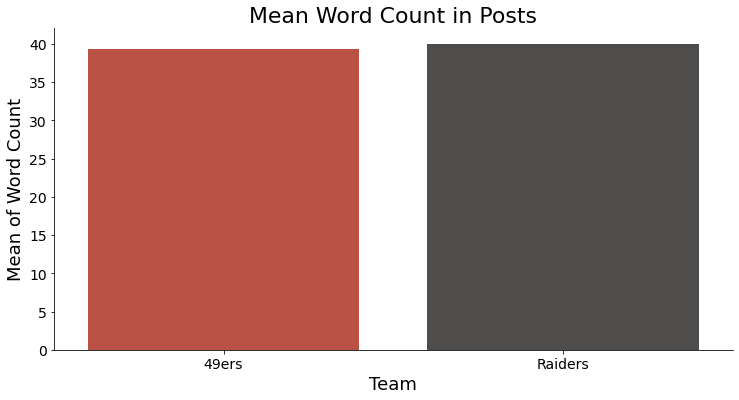

In [41]:
# visualizing the above chart
sns.catplot(data=means,
            x=['49ers', 'Raiders'],
            y=means.loc['word_count'],
            kind='bar',
            height=5,
            aspect=2,
            palette=['#CD4232','#4F4C4C'])
            
plt.title('Mean Word Count in Posts', size=22)
plt.ylabel('Mean of Word Count', size=18)
plt.xlabel('Team', size=18)
plt.yticks(size=14)
plt.xticks(size=14)

plt.savefig('charts/subreddit_mean_postword_counts.png', bbox_inches="tight");

#### ** Interpretation **

We can see from the above word counts that there isn't much difference in mean word count of posts for our subreddits in the 1000 posts we pulled from each.

##### Next...

Below, we will use Vader sentiment analysis to get sentiment scores for each row in 'title_comment' and add them as new columns. This may help our models if there is a significant difference in the sentiment analysis of the two dataframes.

In [42]:
# Instantiating Sentiment Intensity Analyzer and creating a function that 
# creates a new column with the sentiment compound scores

def sentiment_compound(df, col):
    
    sent = SentimentIntensityAnalyzer()
    
    df_sentiments = [sent.polarity_scores(row) for row in df.loc[:,col]]
    sent_values = [[value for value in sent.values()] for sent in df_sentiments]
    df['sentim_val_compounds'] = [i[-1] for i in sent_values]
    return df

In [43]:
# using our new sentiment_compound function
niners_df = sentiment_compound(niners_df, 'title_comment')
niners_df.head()

,id,subreddit,created_utc,title_sent_count,comment_sent_count,title_word_count,comment_word_count,title_comment,sent_count,word_count,sentim_val_compounds
0,q0yp10,49ers,1633323394,1,4,9,30,What do you guys think will happen? Even if he gets a solid win against a strong Arizona. Could they start jimmy? Tell me your thoughts. What happens if Lance balls out next weekend?,5,39,0.8496
1,q0yp0u,49ers,1633323394,5,0,69,0,"[Inman] #team Kyle Shanahan said wasn't anticipating QB switch at halftime until Garoppolo calf too sore to go. And now? ""Trey is there for a reason. Want to give him the time and have him fully ready. But you don’t always have that luxury, and we’ll find that out the next couple days.""",5,69,0.1513
2,q0yiy0,49ers,1633322677,4,0,52,0,"Cameron Salerno: If Kyle Shanahan was a “free agent” coach, he would be off the market within the hour. Does he deserve to be criticized for some decisions? Absolutely. But #team fans who think he should be fired right now are just delusional.",4,52,-0.7269
3,q0ybkx,49ers,1633321852,1,3,13,93,"I have wrote 2 posts where I explained some points about why Kyle isn't getting some criticism that imo he deserves, I wasn't disrespectful or anything and I'm used to seeing a lot of reddit posts that contain criticism and even insults to the HC (I'm a Dodgers fan and Lakers fan, don't judge me). Why do mods delete those types of posts here? I...",4,106,0.6197
4,q0y6sg,49ers,1633321297,1,43,8,955,"I'm not trying to go on a rant or seem delusional (mods please don't delete this I wanna have a nice conversation :))))), I've been a huge Kyle fan and have defended him a lot, but his decision making and comments since the end of the 2020 season have been highly questionable in my opinion.\n\nThe 2020 revenge tour ended and it was clear that t...",44,963,0.9864


In [44]:
# using our new sentiment_compound function
raiders_df = sentiment_compound(raiders_df, 'title_comment')
raiders_df.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,id,subreddit,created_utc,title_sent_count,comment_sent_count,title_word_count,comment_word_count,title_comment,sent_count,word_count,sentim_val_compounds
0,q0xjjk,raiders,1633318718,1,1,14,19,A bunch of misfit toys that everyone thought was washed up but they get the job done their way Hate me if you want but Tampa Bay reminds me of the 70s team,1,33,-0.6808
1,q0xhnu,raiders,1633318509,1,0,11,0,Jon Gruden's QB Camp - Jon Gruden Vs Jon Gruden,1,11,0.0000
2,q0x79r,raiders,1633317385,1,0,22,0,"Was looking at the all time passing list after Brady broke the record, found out Derek Carr is in 62nd place",1,22,-0.4215
3,q0x0ik,raiders,1633316674,1,3,4,46,Anyone have any tips for parking and tail gating at SoFi tomorrow. Coming from San Diego so I’m wondering how early I should go and what the best way to find decent priced parking. It’s my first team game. Parking/tailgates at SoFi.,4,50,0.6369
4,q0wuqb,raiders,1633316102,2,0,9,0,She's ready for tomorrow's game! RNFL,2,9,0.4199


In [45]:
niners_df['sentim_val_compounds'].mean()

0.11389467213114747

In [46]:
raiders_df['sentim_val_compounds'].mean()

0.1899493852459016

Now we will lemmatize the words, to get the base or root of the words. This may help our model or might not, so we will have to try and see.

In [47]:
# Instantiating lemmatizer and creating function that lemmatizes text in a df[col]

def lemmatize_posts(df, col):
    lemmatizer = WordNetLemmatizer()
    df.loc[:, col] = [lemmatizer.lemmatize(word) for word in df.loc[:, col]]
    return df

In [48]:
# using our new function on our dfs

niners_df = lemmatize_posts(niners_df, 'title_comment')
raiders_df = lemmatize_posts(raiders_df, 'title_comment')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Now we will combine the two dataframes into one to put into our model.

In [49]:
# combining the dfs
df = pd.concat([niners_df, raiders_df], axis=0)

In [50]:
# checking out our new df
df

,id,subreddit,created_utc,title_sent_count,comment_sent_count,title_word_count,comment_word_count,title_comment,sent_count,word_count,sentim_val_compounds
0,q0yp10,49ers,1633323394,1,4,9,30,What do you guys think will happen? Even if he gets a solid win against a strong Arizona. Could they start jimmy? Tell me your thoughts. What happens if Lance balls out next weekend?,5,39,0.8496
1,q0yp0u,49ers,1633323394,5,0,69,0,"[Inman] #team Kyle Shanahan said wasn't anticipating QB switch at halftime until Garoppolo calf too sore to go. And now? ""Trey is there for a reason. Want to give him the time and have him fully ready. But you don’t always have that luxury, and we’ll find that out the next couple days.""",5,69,0.1513
2,q0yiy0,49ers,1633322677,4,0,52,0,"Cameron Salerno: If Kyle Shanahan was a “free agent” coach, he would be off the market within the hour. Does he deserve to be criticized for some decisions? Absolutely. But #team fans who think he should be fired right now are just delusional.",4,52,-0.7269
3,q0ybkx,49ers,1633321852,1,3,13,93,"I have wrote 2 posts where I explained some points about why Kyle isn't getting some criticism that imo he deserves, I wasn't disrespectful or anything and I'm used to seeing a lot of reddit posts that contain criticism and even insults to the HC (I'm a Dodgers fan and Lakers fan, don't judge me). Why do mods delete those types of posts here? I...",4,106,0.6197
4,q0y6sg,49ers,1633321297,1,43,8,955,"I'm not trying to go on a rant or seem delusional (mods please don't delete this I wanna have a nice conversation :))))), I've been a huge Kyle fan and have defended him a lot, but his decision making and comments since the end of the 2020 season have been highly questionable in my opinion.\n\nThe 2020 revenge tour ended and it was clear that t...",44,963,0.9864
...,...,...,...,...,...,...,...,...,...,...,...
83,pwij1h,raiders,1632753734,1,28,9,406,"[Previous Post](https://www.reddit.com/r/team/comments/pvic95/going_to_my_first_game/)\n\nHands down one of the greatest things I have ever done in my life. The game started off...interesting, as we all know. But spirits were high and the stadium was electric. When we pinned them on the 1, the crowd was going crazy, especially when they got int...",28,415,0.9942
84,pwifb2,raiders,1632753426,1,0,3,0,History repeats itself,1,3,0.0000
85,pwidxn,raiders,1632753307,1,23,9,367,"I am the sole reason for all of your stress yesterday. If it wasn’t for me, the game wouldn’t have been so close. \n\nI am a 25 y/o lifelong fan. I’ve known nothing but sorrow as a team fan. I superstitiously say I’m not superstitious. But this year, as part of my budget grocery shopping I’ve found myself with Totino’s pizza (you can get full o...",24,376,0.9853
86,pwi0i5,raiders,1632752182,1,0,8,0,Las Vegas team Game Day 09 26 2021,1,8,0.0000


In [51]:
# Converting our target 'subreddit' to binary 0/1

df['subreddit'] = (df['subreddit'] == '49ers')*1

# checking our target columns baseline accuracy
df['subreddit'].value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

#### Our target's baseline accuracy is 0.5 or 50%.
We will try to beat this baseline with our models.

#### Statistical significance analysis of compound values of sentiment analysis and the subreddit target column

Null Hypothesis: The mean difference between the sentiment analysis values' compound of 49ers subreddit posts and Raiders subreddit posts is not statistically significant.

Alternative Hypothesis: The mean difference between the sentiment analysis values' compound of 49ers subreddit posts and Raiders subreddit posts is statistically significant.

In [52]:
# checking for statistical significance of the compound values of sentiment analysis and the subreddit target column
# ⍺ = 0.05
X = df[['sentim_val_compounds']]
y = df['subreddit']

X = sm.add_constant(X, prepend=True)
results = sm.OLS(y, X).fit()
results.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              subreddit   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.170
Date:                Sat, 09 Oct 2021   Prob (F-statistic):            0.00754
Time:                        00:11:15   Log-Likelihood:                -704.79
No. Observations:                 976   AIC:                             1414.
Df Residuals:                     974   BIC:                             1423.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5146      0.017     30.508      0.000       0.481       0.548
sentim_val_compounds    -0.0961      0.036     -2.678      0.008      -0.167      -0.026
==============================================================================
Omnibus:                     3747.265   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.000
Skew:                          -0.001   Prob(JB):                     4.91e-35
Kurtosis:                       1.029   Cond. No.                         2.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ** Interpretation **

From our summary statistics we can see our p-value of 0.008 is less than our ⍺ of 0.05. We can reject our null hypothesis and assume that there is a statistical significance in the mean values of sentiment analysis values' compound of 49ers subreddit posts and Raiders subreddit posts. So we will include it in our features of our model later.

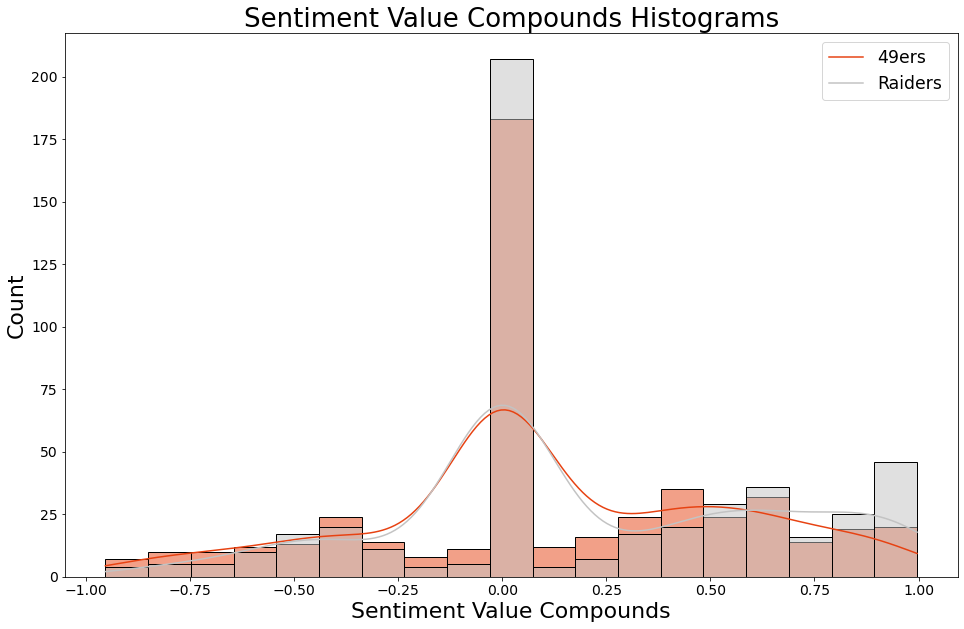

In [53]:
# displaying the distribution of sentiment values' compounds

plt.figure(figsize=(16,10))
sns.histplot(x=df['sentim_val_compounds'],
             hue=df['subreddit'],
             palette=['#C3C3C3', '#E74212'],
             kde=True, legend=True)
labels = ['49ers', 'Raiders']
plt.legend(labels=labels, fontsize='xx-large')
plt.title('Sentiment Value Compounds Histograms', size=26)
plt.xlabel('Sentiment Value Compounds', size=22)
plt.ylabel('Count', size=22)
plt.xticks(size=14)
plt.yticks(size=14)

plt.savefig('charts/sentiment_compounds.png', bbox_inches='tight');

In [54]:
# Creating an X variable for our text posts in just the niners_df

Xn = niners_df['title_comment']
X_n = niners_df['title_comment']

In [55]:
# checking the 'english' stop-words for the text vectorizer
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [56]:
# adding some words to the list

new_words = list(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

for word in ['to', 'and', 'of', 'in', 'for', 'k', 'ok', 'okay', 'like', 'team']:
    new_words.append(word)

In [57]:
# checking our new words list
new_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Below we will compare CountVectorizer and TFIDVectorizer on the two separate dfs before we move on to modeling the data on the combined df. This will also give us a better idea of which words are most common in each subreddit.

In [58]:
# Count Vectorizing the 'title_comment' column for niners_df

cv = CountVectorizer(stop_words=new_words)
cv.fit(Xn)
Xn_train = cv.transform(Xn)

print(Xn_train.shape)


tfid = TfidfVectorizer(stop_words=new_words)

tfid.fit(X_n)
X_n_train = tfid.transform(X_n)
X_n_train.shape

(488, 2814)


(488, 2814)

In [59]:
# code from lesson 5.04
# Converting Xn_train into a DataFrame (CV)

Xn_train_df = pd.DataFrame(Xn_train.todense(), 
                          columns=cv.get_feature_names())
Xn_train_df.head()

,00,000,02,03,05,09,10,100,105,11,...,yet,yl,young,youth,youtube,zach,zachariason,zero,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,3,0,0,0,...,0,0,2,0,0,0,0,0,0,0


In [60]:
# Converting X_n_train into a DataFrame (TFID)

X_n_train_df = pd.DataFrame(X_n_train.todense(), 
                          columns=tfid.get_feature_names())
X_n_train_df.head()

,00,000,02,03,05,09,10,100,105,11,...,yet,yl,young,youth,youtube,zach,zachariason,zero,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.093991,0.0,0.0,0.0,...,0.0,0.0,0.074403,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
Xr = raiders_df['title_comment']
X_r = raiders_df['title_comment']

In [62]:
# Count Vectorizing the 'title' column for raiders_df

cv2 = CountVectorizer(stop_words=new_words)
cv2.fit(Xr)
Xr_train = cv2.transform(Xr)

print(Xr_train.shape)

tfid2 = TfidfVectorizer(stop_words=new_words)

tfid2.fit(X_r)
X_r_train = tfid2.transform(X_r)
X_r_train.shape

(488, 2989)


(488, 2989)

In [63]:
# Converting Xr_train into a DataFrame (CV)

Xr_train_df = pd.DataFrame(Xr_train.todense(), 
                          columns=cv2.get_feature_names())
Xr_train_df.head()

,00,000,035fe35f019,04,07,09,10,100,100x,10th,...,yo,youre,youtu,youtube,ypc,yrds,ysk,yt,zay,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Converting X_r_train into a DataFrame (TFID)

X_r_train_df = pd.DataFrame(X_r_train.todense(), 
                          columns=tfid2.get_feature_names())
X_r_train_df.head()

,00,000,035fe35f019,04,07,09,10,100,100x,10th,...,yo,youre,youtu,youtube,ypc,yrds,ysk,yt,zay,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# creating a function that returns the top nmost common words (we will use it now and later)

def top_words_niners(n):
    return X_n_train_df.sum().sort_values(ascending=False).head(n)

def top_words_raiders(n):
    return X_r_train_df.sum().sort_values(ascending=False).head(n)

In [66]:
# creating new variables for top 10 most common for both CV and TFID vectorizations

niners_top_10_cv = Xn_train_df.sum().sort_values(ascending=False).head(10)
niners_top_10_tfid = X_n_train_df.sum().sort_values(ascending=False).head(10)

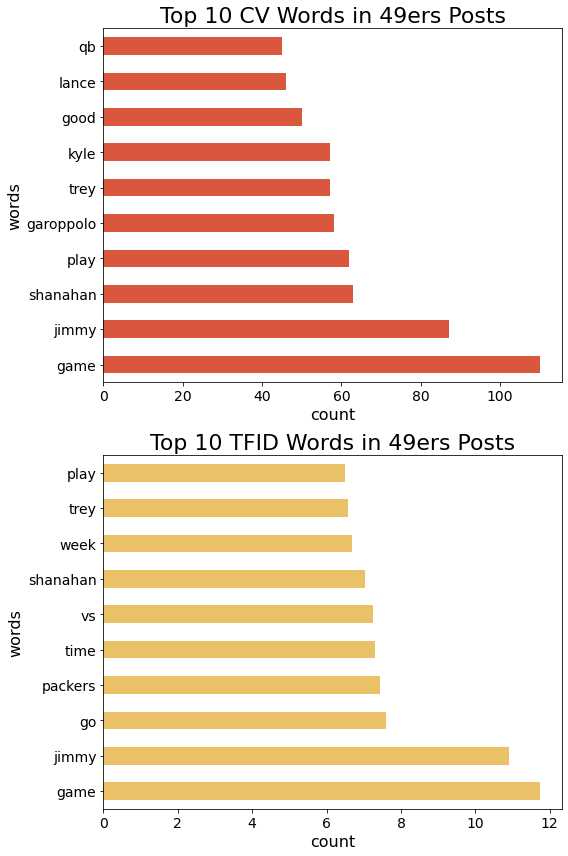

In [67]:
# plotting top occuring words in cv: 49ers
fig, ax = plt.subplots(2, 1, figsize=(8,12))
ax = plt.subplot(2, 1, 1)
ax = Xn_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='#D9573C'
                                                                 )
ax.set_title('Top 10 CV Words in 49ers Posts', size=22)
ax.set_xlabel('count', size=16)
ax.set_ylabel('words', size=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# plotting top occuring words in tfid: 49ers
ax2 = plt.subplot(2, 1, 2)
ax2 = X_n_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='#EBC167',
                                                                 title = 'Top 10 TFID Words in 49ers Posts',
                                                                 )
ax2.set_title('Top 10 TFID Words in 49ers Posts', size=22)
ax2.set_xlabel('count', size=16)
ax2.set_ylabel('words', size=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('charts/niners_top_words_1.png', bbox_inches='tight');

In [68]:
# creating new variables for top 10 most common for both CV and TFID vectorizations

raiders_top_10_cv = Xr_train_df.sum().sort_values(ascending=False).head(10)
raiders_top_10_tfid = X_r_train_df.sum().sort_values(ascending=False).head(10)

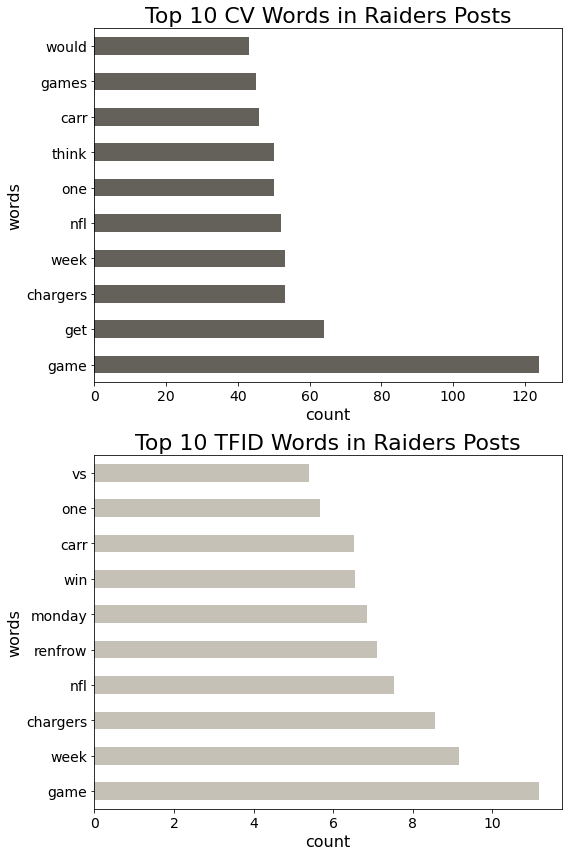

In [69]:
# plotting top occuring words in cv: Raiders
fig, ax = plt.subplots(2, 1, figsize=(8,12))
ax = plt.subplot(2, 1, 1)
ax = Xr_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='#64615B',
                                                                 title = 'Top 10 CV Words in Raiders Posts',
                                                                 )
ax.set_title('Top 10 CV Words in Raiders Posts', size=22)
ax.set_xlabel('count', size=16)
ax.set_ylabel('words', size=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# plotting top occuring words in tfid: Raiders
ax2 = plt.subplot(2, 1, 2)
ax2 = X_r_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='#C5C1B7',
                                                                 title = 'Top 10 TFID Words in Raiders Posts',
                                                                 )
ax2.set_title('Top 10 TFID Words in Raiders Posts', size=22)
ax2.set_xlabel('count', size=16)
ax2.set_ylabel('words', size=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('charts/raiders_top_words_1.png', bbox_inches='tight');

We can see that the top words from the TFID Vectorizer seem to be normalized as the TFID looks at words most common across all documents (posts) rather than just most common overall, so we will move forward with the TFID Vectorized columns. It seems to be more useful since we are trying to find patterns in the data that our model can learn from to make predictions.

### Before we model...

Looking over our data and all of the features we engineered that seem to have some patterns/statistical significance in them, we believe that we have enough data to be able to create a model that does much better than our baseline.

In [70]:
# checking the shape of our combined df before we vectorize
df.shape

(976, 11)

In [71]:
# vectorizing the data
X = df['title_comment']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

In [72]:
# TFID Vectorizing the 'title' column
tfid3 = TfidfVectorizer(stop_words=new_words)
tfid3.fit(X_train)
X_train = tfid3.transform(X_train)
X_test = tfid3.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(732, 3924)
(244, 3924)


In [73]:
# checking the type of our new vectorized training data
type(X_train)

scipy.sparse.csr.csr_matrix

In [74]:
# code from lesson 5.04
# Converting X_train into a DataFrame so we can check our top words

X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=tfid3.get_feature_names())
X_train_df.head()

,00,000,035fe35f019,04,07,09,10,100,100x,11,...,youtu,youtube,ypc,yrds,yt,zachariason,zay,zero,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


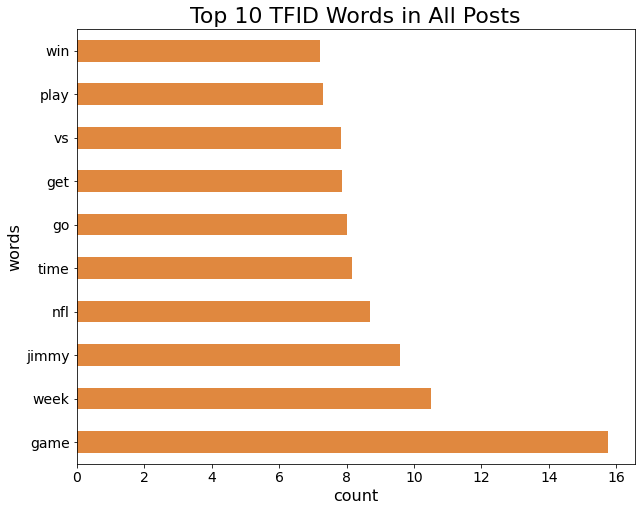

In [75]:
# plotting top occuring words across documents

plt.figure(figsize=(10,8))
top_10=X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='#E0883F',
                                                                 title = 'Top 10 Words in All Posts',
                                                                 )
plt.title('Top 10 TFID Words in All Posts', size=22)
plt.xlabel('count', size=16)
plt.ylabel('words', size=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('charts/subreddits_top_words_1.png', bbox_inches='tight');

#### ** Interpretation **

Most of the top occuring words across all post are not surprising considering the subject, except 'jimmy', which is generally associated with Jimmy Garapolo of the 49ers. Jimmy is just a very common name and it's possible there are also players for the Raiders or Raider's opponents named Jimmy that are being talked about.

In [76]:
# checking out the parameters for TfidVectorizer for our model params
TfidfVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [77]:
# Reinstantiating our X and y to put into our GridSearchCV model which will use a pipeline to vectorize the text
X = df['title_comment']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

In [78]:
# code from lesson 6.03
# Patrick's code
# Instantiating a count and empty dictionary to start collecting our model metrics for comparison
count = 0
model_params = {}

In [79]:
# First model: GridsearchCV with pipeline using TfidVectorizer and MultinomialNB Classifier

model_params = model_params
count = count


pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

params = {
    'tfid__max_df': [0.83, 0.88, .91],
    'tfid__min_df': [.05, 0.1],
    'tfid__max_features': [1500, 2000, 3000],
    'tfid__ngram_range': [(1,1), (1,2)],
    'tfid__stop_words': [new_words],
    'mnb__alpha': [0.1, 0.2]
}

mnb_grid = GridSearchCV(pipe,
                        param_grid=params,
                        cv=3,
                        verbose=1)

mnb_grid.fit(X_train, y_train)

# Collecting model info and metrics into a dictionary and converting to a df
count += 1

mnb_grid.best_params_['score'] = mnb_grid.best_score_
mnb_grid.best_params_['estimator'] = mnb_grid.estimator
model_params[f'model_{count}'] = mnb_grid.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    8.0s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator
model_1,0.1,0.83,1500,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())"


In [80]:
# checking scores on training and testing to check bias and variance
print(mnb_grid.score(X_train, y_train))
print(mnb_grid.score(X_test, y_test))

0.6024590163934426
0.569672131147541


The scores are not much better than the baseline, and the variance could be a little better.

In [81]:
# creating function to get more metrics into a list of variables (to make a df with)

def get_metrics(model, v_train, v_test):
    model_name = f'model{count}'
    best_estimator = model.best_estimator_
    X_train_score = model.score(v_train, y_train)
    X_test_score = model.score(v_test, y_test)
    best_score = model.best_score_
    return ([model_name, best_estimator, X_train_score, X_test_score, best_score])

In [82]:
# instantiating a new cleaner df to store our model metrics using our function from above

model1 = get_metrics(mnb_grid, X_train, X_test)

comp = pd.DataFrame(model1, index=['model #', 'best_estimator', 'X_train_score', 
                              'X_test_score', 'best_score']).T

In [83]:
# Instantiating comparison df function to add  a row for each new model
def model_comparison(model, v_train, v_test):
    new_df = pd.DataFrame(get_metrics(model, v_train, v_test),index=['model #', 'best_estimator', 'X_train_score', 
                              'X_test_score', 'best_score']).T
    return comp.merge(new_df, how='outer', on=['model #', 'best_estimator', 'X_train_score', 
                              'X_test_score', 'best_score'])

In [84]:
# checking out our new df

comp

,model #,best_estimator,X_train_score,X_test_score,best_score
0,model1,"(TfidfVectorizer(max_df=0.83, max_features=1500, min_df=0.05,\n stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',\n 'ourselves', 'you', ""you're"", ""you've"", ""you'll"",\n ""you'd"", 'your', 'yours', 'yourself', 'yourselves',\n 'he', 'him', 'his'...",0.602459,0.569672,0.569672


Our first model's score is pretty low, it's only about 6% points above the baseline of 0.5. We can try another model to see maybe there's a better model to use, before we try manipulating our features further.

Below we will look at our predictions vs. our correctly and incorrectly predicted values to see how they skew.

In [85]:
# creating a function that generates confusion matrix and metrics


def confusion_mat(model, X_test, y_test, cmap):
    
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    # metrics
    acc_score = model.score(X_test, y_test)
    sensitivity = recall_score(y_test, preds)
    specificity = tn / (tn + fp)
    precision = precision_score(y_test, preds)
    print (f'Accuracy Score: {acc_score}')
    print (f'Specificity Score: {specificity}')
    print (f'Sensitivity Score: {sensitivity}')
    print (f'Precision Score: {precision}')

    return plot_confusion_matrix(model, X_test, y_test, cmap=cmap, 
                      values_format='d', display_labels=['49ers', 'Raiders'])


Accuracy Score: 0.569672131147541
Specificity Score: 0.860655737704918
Sensitivity Score: 0.2786885245901639
Precision Score: 0.6666666666666666


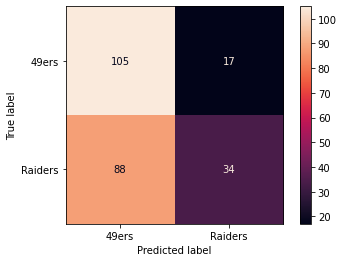

In [86]:
# using our new function
confusion_mat(mnb_grid, X_test, y_test, 'rocket');

#### ** Interpretation **

Our 'positive' in our confusion matrix above is the 49ers' Subreddit (denoted by 1 in our 'subreddit' column) and the 'negative' is the Raiders' Subreddit.


From our confusion matrix we can see that our sensitivity, or true positive rate, is very low at 27%. While our model does not do a good job at predicting either postives or negatives, it predicts 49ers far more than Raiders, and far more than it should. The false positives are 88 and false negatives are 17, which tells us that the model seems to have more data that allows it to predict the 49ers subreddit correctly more often than the Raiders subreddit, but it also predicts 49ers more than twice as much as Raiders and has many false positives. When we optimize our features, we will make sure to also minimize for this data skew by choosing an equal amount of features that relate to each subreddit.

In [87]:
# reinstantiating our X and y again to create a vectorized df which we will use for our following models
X = df['title_comment']
y = df['subreddit']

In [88]:
# Count Vectorizing the 'title' column
tfid4 = TfidfVectorizer(stop_words=new_words)
tfid4.fit(X)
X_train = tfid4.transform(X)
X_train.shape

(976, 4554)

In [89]:
# Converting X_train into a DataFrame

X_df = pd.DataFrame(X_train.todense(), 
                          columns=tfid4.get_feature_names())
X_df.head()

,00,000,02,03,035fe35f019,04,05,07,09,10,...,ypc,yrds,ysk,yt,zach,zachariason,zay,zero,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# writing over our X variable with our new vectorized df
X=X_df
# train, test, splitting on our X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [91]:
# code from lesson 6.01
# Using GridSearch CV with Decision Tree Classifier

model_params = model_params
count=count

dt = DecisionTreeClassifier()

params = {
    'max_depth': [None, 5, 6],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'max_features': [2000, 3000]}

dt_grid = GridSearchCV(dt,
                       param_grid=params,
                       cv=5,
                       verbose=1)

# Fit model
dt_grid.fit(X_train, y_train)

count += 1
dt_grid.best_params_['score'] = dt_grid.best_score_
dt_grid.best_params_['estimator'] = dt_grid.estimator
model_params[f'model_{count}'] = dt_grid.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   52.3s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,min_samples_leaf,min_samples_split
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),None,3000.0,2.0,3.0


In [92]:
# accuracy score (classifying)
print(f'Training Score: {dt_grid.score(X_train, y_train)}')
print(f'Testing Score: {dt_grid.score(X_test, y_test)}')

Training Score: 0.9153005464480874
Testing Score: 0.7131147540983607


In [93]:
# adding model row to comp df
comp = model_comparison(dt_grid, X_train, X_test)

Accuracy Score: 0.7131147540983607
Specificity Score: 0.8114754098360656
Sensitivity Score: 0.6147540983606558
Precision Score: 0.7653061224489796


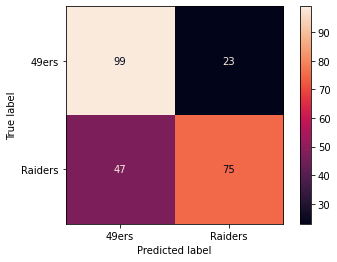

In [94]:
# confusion matrix and metrics to check errors
confusion_mat(dt_grid, X_test, y_test, 'rocket');

#### ** Interpretation **

Our Decision Tree Classifier did a much better job at predicting our target classes than our MNB model. We can see a much higher sensitivity score here than the previous. Our X_train and X_test scores are also much higher but have quite a bit of variance.

In [95]:
# Checking predictions vs actuals

preds = dt_grid.predict(X_test)
residuals = y_test - preds
dt_grid_preds = pd.DataFrame({
    'actuals': y_test,
    'residuals': preds
})
dt_grid_preds

,actuals,residuals
70,1,1
96,0,0
21,0,0
70,0,1
28,0,0
...,...,...
8,1,0
52,1,1
2,1,0
0,0,0


In [96]:
# Finding the index of errors so we can see the rows and text that the model missed
errors = dt_grid_preds[dt_grid_preds['actuals'] != dt_grid_preds['residuals']].index
errors

Int64Index([70, 49, 79, 98, 39, 34, 15, 40, 40, 43, 77, 78, 59, 91,  8, 48, 79,
            47,  5, 76,  7, 23, 41, 49, 64, 82, 62, 64, 68, 79, 40, 20, 16, 25,
            53, 39, 83, 48, 93, 95, 99, 56, 51, 79, 29, 69, 38, 75, 17, 21, 52,
            74, 61, 94, 31,  0, 72, 53, 71, 41, 95, 14, 78, 59, 57, 33, 60, 28,
             8,  2],
           dtype='int64')

Let's look into the ones the model incorrectly predicted to see if we can figure out why and make some updates to our data.

In [97]:
df.iloc[[28, 98, 98, 95, 24, 11], :]

,id,subreddit,created_utc,title_sent_count,comment_sent_count,title_word_count,comment_word_count,title_comment,sent_count,word_count,sentim_val_compounds
28,q0vhhc,1,1633311062,1,2,4,36,Too lazy to confirm but I’m certain we have a losing record at Levi’s. Except for 2019 we’ve had shit for shit to cheer for at this place. Tired of Leaving Losers,3,40,-0.9538
98,q0bqse,1,1633240062,1,2,12,34,"Have season tickets and are flying up this time so don’t need parking. If you are going to the game and want a free parking pass, hit me up. Hey Faithful, anyone need parking for Sunday’s game?",3,46,0.7579
98,q0bqse,1,1633240062,1,2,12,34,"Have season tickets and are flying up this time so don’t need parking. If you are going to the game and want a free parking pass, hit me up. Hey Faithful, anyone need parking for Sunday’s game?",3,46,0.7579
95,q0ctea,1,1633245151,1,4,15,63,"Sorry for the non-football related question. I'm going to my first game in years and my phone's battery depletes really quickly. I was wondering if they will allow portable chargers into Levi's. I bring mine into Oracle Park for Giants games with no problem but Levi's Stadium policy says no ""battery packs"" are allowed Do you regulars that go to...",4,78,-0.6059
24,q0votp,1,1633311822,1,0,10,0,Lance made NFL history on long TD pass vs. Seahawks,1,10,0.0000
11,q0x5r5,1,1633317221,1,0,2,0,team pack💨,1,2,0.0000


A few of the above are pretty obviously one team or the other (by player names or cities mostly), but a few are so vague and neutral in text that they would be very difficult for even humans to predict correctly. This tells me that our model should probably not get 100% accuracy, but I think we can do better than we've done so far. Before we change any features, let's try using ADA Boost Classifier with the Decision Tree to see if it will make any difference.

In [98]:
# reinstantiating X and y for our next model
X=X_df
y=df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [99]:
model_params = model_params
count = count

# Using GridSearchCV with ADA boost Classifier with base estimator Decision Tree Classifier to try to boost our scores

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

ada_params = {
    'n_estimators': [15, 18],
    'learning_rate': [0.4, 0.5],
    'base_estimator__max_depth': [None, 5],
#     'base_estimator__min_samples_split': [3, 4],
#     'base_estimator__min_samples_leaf': [3, 4],
    'base_estimator__max_features': [2000, 3000]
}

ada_dt_grid = GridSearchCV(ada,
                           param_grid=ada_params,
                           cv=5,
                           verbose=1)

ada_dt_grid.fit(X_train, y_train)


count += 1

ada_dt_grid.best_params_['score'] = ada_dt_grid.best_score_
ada_dt_grid.best_params_['estimator'] = ada_dt_grid.estimator
model_params[f'model_{count}'] = ada_dt_grid.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   56.5s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,min_samples_leaf,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),None,3000.0,2.0,3.0,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,5.0,3000.0,0.4,18.0


In [100]:
# checking best params
ada_dt_grid.best_params_

{'base_estimator__max_depth': 5,
 'base_estimator__max_features': 3000,
 'learning_rate': 0.4,
 'n_estimators': 18,
 'score': 0.7417668437237909,
 'estimator': AdaBoostClassifier(base_estimator=DecisionTreeClassifier())}

In [101]:
# checking best score
ada_dt_grid.best_score_

0.7417668437237909

In [102]:
# adding model row to comp df
comp = model_comparison(ada_dt_grid, X_train, X_test)

In [103]:
# checking out our comparison df
comp

,model #,best_estimator,X_train_score,X_test_score,best_score
0,model1,"(TfidfVectorizer(max_df=0.83, max_features=1500, min_df=0.05,\n stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',\n 'ourselves', 'you', ""you're"", ""you've"", ""you'll"",\n ""you'd"", 'your', 'yours', 'yourself', 'yourselves',\n 'he', 'him', 'his'...",0.602459,0.569672,0.569672
1,model2,"DecisionTreeClassifier(max_features=3000, min_samples_leaf=2,\n min_samples_split=3)",0.915301,0.713115,0.730901
2,model3,"(DecisionTreeClassifier(max_depth=5, max_features=3000, random_state=277145907), DecisionTreeClassifier(max_depth=5, max_features=3000, random_state=159797690), DecisionTreeClassifier(max_depth=5, max_features=3000, random_state=709689268), DecisionTreeClassifier(max_depth=5, max_features=3000, random_state=2086342124), DecisionTreeClassifier(m...",0.915301,0.721311,0.741767


In [104]:
# accuracy score (classifying)
print(f'Training Score: {ada_dt_grid.score(X_train, y_train)}')
print(f'Testing Score: {ada_dt_grid.score(X_test, y_test)}')

Training Score: 0.9153005464480874
Testing Score: 0.7213114754098361


Accuracy Score: 0.860655737704918
Specificity Score: 0.9426229508196722
Sensitivity Score: 0.7786885245901639
Precision Score: 0.9313725490196079


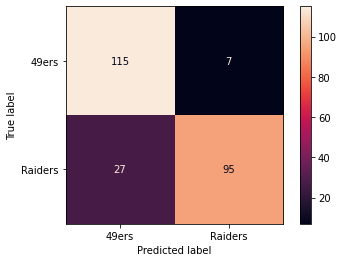

In [105]:
# confusion matrix and metrics
confusion_mat(dt_grid, X_test, y_test, 'rocket');

Our scores aren't so great. We have a pretty high variance in training and testing scores. Let's limit our features and use polynomials with correlation.

In [106]:
# dropping any columns we won't use as features from non-vectorized combined df
df_x = df.drop(columns=['title_comment', 'id', 'created_utc'])
# removing 'subreddit' column from vectorized df
X_df = X_df.drop(columns=['subreddit'])
# resetting index to be able to concat
df_x.reset_index(drop=True, inplace=True)
X_df.reset_index(drop=True, inplace=True)

In [107]:
# code help from https://www.geeksforgeeks.org/find-columns-shared-by-two-data-frames/
np.intersect1d(df_x.columns,X_df.columns)

array([], dtype=object)

In [108]:
# concatening vectorized columns with columns we'll use as features from our original df
new_df = pd.concat([df_x, X_df], axis=1)
new_df

,subreddit,title_sent_count,comment_sent_count,title_word_count,comment_word_count,sent_count,word_count,sentim_val_compounds,00,000,...,ypc,yrds,ysk,yt,zach,zachariason,zay,zero,zip,zone
0,1,1,4,9,30,5,39,0.8496,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,5,0,69,0,5,69,0.1513,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,1,4,0,52,0,4,52,-0.7269,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,1,1,3,13,93,4,106,0.6197,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,1,1,43,8,955,44,963,0.9864,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,0,1,28,9,406,28,415,0.9942,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
972,0,1,0,3,0,1,3,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
973,0,1,23,9,367,24,376,0.9853,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137041
974,0,1,0,8,0,1,8,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [109]:
# looking at top 20 correlations with 'subreddit'
new_df.corr()['subreddit'].sort_values(ascending=False)[:20]

subreddit           1.000000
title_word_count    0.278660
jimmy               0.212816
shanahan            0.190633
garoppolo           0.178117
packers             0.177782
kyle                0.175842
lance               0.172742
lombardi            0.166848
trey                0.159242
title_sent_count    0.148572
kittle              0.141774
seahawks            0.138133
calf                0.126720
george              0.115541
williams            0.110392
sf                  0.106568
sherman             0.105932
norman              0.103698
david               0.102787
Name: subreddit, dtype: float64

In [110]:
# Creating a df of top positive and negative correlations with 'subreddit' (our target)

subreddit_corr = new_df.corr()['subreddit']

subreddit_word_corr = {}
for index, corr in subreddit_corr.items():
    if corr > 0.1 or corr < -0.09:
        subreddit_word_corr[index] = corr
        
subreddit_word_corr = pd.DataFrame(subreddit_word_corr.items(), columns=['Id', 'corr']).set_index('Id')
subreddit_word_corr.sort_values(by='corr', ascending=False)

,corr
Id,
subreddit,1.000000
title_word_count,0.278660
jimmy,0.212816
shanahan,0.190633
garoppolo,0.178117
packers,0.177782
kyle,0.175842
lance,0.172742
lombardi,0.166848


In [111]:
# dropping 'subreddit' as we know it's 100% correlated with itself
subreddit_word_corr.drop(index='subreddit', inplace=True)

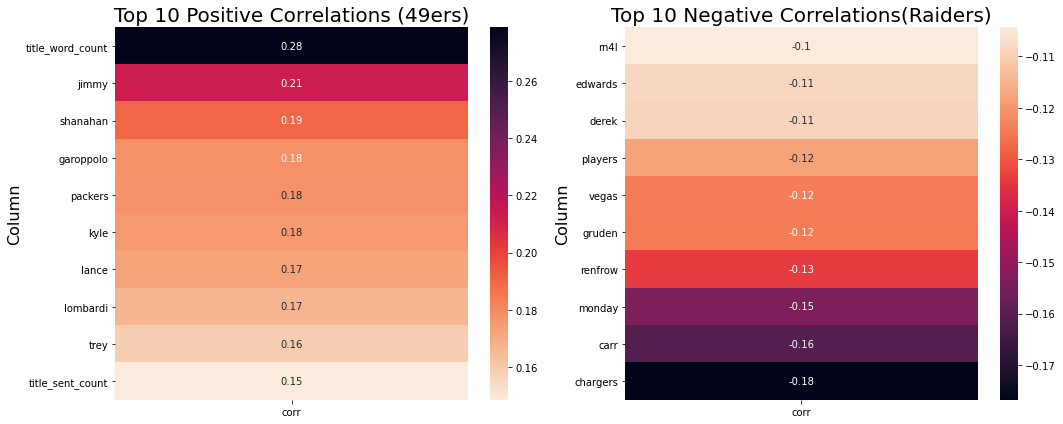

In [112]:
# Heatmap of top 10 positive and top 10 negative correlations with 'subreddit' (target)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax = plt.subplot(1, 2, 1)
ax = sns.heatmap(data=subreddit_word_corr.sort_values(by='corr', ascending=False)[:10],
                 annot=True,
                 cmap='rocket_r')
ax.set_title('Top 10 Positive Correlations (49ers)', size=20)
ax.set_ylabel('Column', size=16)
ax2 = plt.subplot(1, 2, 2)
ax2 = sns.heatmap(data=subreddit_word_corr.sort_values(by='corr', ascending=False)[-10:],
                  annot=True,
                  cmap='rocket')
ax2.set_title('Top 10 Negative Correlations(Raiders)', size=20)
ax2.set_ylabel('Column', size=16)
fig.tight_layout()

plt.savefig('charts/subreddit_corr_1.png', bbox_inches='tight');

#### ** Interpretations **

Our positive correlations are all 49er related words, since subreddit = 1 is 49ers and Raiders correlated for our negatively correlated values since subreddit = 0 is Raiders. 

We can see some of the highest correlated columns in our features are:

- 'title_word_count' with 49ers, since there was a pretty big difference in the mean word counts, we expected this
- 'jimmy' who is the starting Quarterback for the 49ers, not surprising he gets a lot of mentions in the 49ers subreddit
- 'chargers' whom the Raiders played in the Monday Night Football game this past week
- 'carr' the Raiders quarterback, so nothing too surprising here
- One surpirsing correlation here may be 'players' on the Raiders side, since we would assume 'players' are mentioned in any football subreddit, including the 49ers' subreddit, but seem to correlate more with the Raiders here. 

In [113]:
# index to use for our features
subreddit_word_corr.index

Index(['title_sent_count', 'title_word_count', 'black', 'calf', 'carr',
       'chargers', 'david', 'derek', 'dolphins', 'edwards', 'francisco',
       'garoppolo', 'george', 'gruden', 'hunter', 'jimmy', 'kittle', 'kyle',
       'la', 'lance', 'las', 'lombardi', 'maxx', 'monday', 'norman', 'packers',
       'players', 'renfrow', 'rn4l', 'ruggs', 'seahawks', 'sf', 'shanahan',
       'sherman', 'trey', 'vegas', 'williams'],
      dtype='object', name='Id')

In [114]:
# Instantiating new X and y using our new highest correlated features
features = list(subreddit_word_corr.index)
X = new_df[features]
y = new_df['subreddit']

# creating polynomials from our new X
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# converting polynomials to df
X_poly = pd.DataFrame(data=X_poly, columns = poly.get_feature_names(features))
X_poly['subreddit'] = y

In [115]:
# checking out our polynomials
poly.get_feature_names(features)

['title_sent_count',
 'title_word_count',
 'black',
 'calf',
 'carr',
 'chargers',
 'david',
 'derek',
 'dolphins',
 'edwards',
 'francisco',
 'garoppolo',
 'george',
 'gruden',
 'hunter',
 'jimmy',
 'kittle',
 'kyle',
 'la',
 'lance',
 'las',
 'lombardi',
 'maxx',
 'monday',
 'norman',
 'packers',
 'players',
 'renfrow',
 'rn4l',
 'ruggs',
 'seahawks',
 'sf',
 'shanahan',
 'sherman',
 'trey',
 'vegas',
 'williams',
 'title_sent_count title_word_count',
 'title_sent_count black',
 'title_sent_count calf',
 'title_sent_count carr',
 'title_sent_count chargers',
 'title_sent_count david',
 'title_sent_count derek',
 'title_sent_count dolphins',
 'title_sent_count edwards',
 'title_sent_count francisco',
 'title_sent_count garoppolo',
 'title_sent_count george',
 'title_sent_count gruden',
 'title_sent_count hunter',
 'title_sent_count jimmy',
 'title_sent_count kittle',
 'title_sent_count kyle',
 'title_sent_count la',
 'title_sent_count lance',
 'title_sent_count las',
 'title_sent_coun

In [116]:
# getting only highest correlated features from our new polynomial X_poly
subreddit_corr_poly = X_poly.corr()['subreddit']

subreddit_word_corr_poly = {}
for index, corr in subreddit_corr_poly.items():
    if corr > 0.17 or corr < -0.12:
        subreddit_word_corr_poly[index] = corr
        
subreddit_word_corr_poly = pd.DataFrame(subreddit_word_corr_poly.items(), columns=['Id', 'corr']).set_index('Id')
subreddit_word_corr_poly.sort_values(by='corr', ascending=False)

,corr
Id,
subreddit,1.000000
title_word_count,0.278660
jimmy,0.212816
title_sent_count title_word_count,0.197818
title_sent_count jimmy,0.193348
shanahan,0.190633
title_word_count shanahan,0.181736
title_sent_count shanahan,0.179032
title_word_count jimmy,0.178837


In [117]:
# dropping 'subreddit' as we know it's 100% correlated with itself
subreddit_word_corr_poly.drop(index='subreddit', inplace=True)

In [118]:
# Resintantiating X with new highest correlated poly features and doing train, test, split
features_poly = list(subreddit_word_corr_poly.index)
X = X_poly[features_poly]

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state=20)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test  = sc.transform(X_test)

In [119]:

model_params = model_params
count = count


ada_poly = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

ada_params = {
    'n_estimators': [10, 15],
    'learning_rate': [0.4, 0.5, 0.6],
    'base_estimator__max_depth': [2, 3]
}

ada_dt_grid_poly = GridSearchCV(ada_poly,
                      param_grid=ada_params,
                      cv=5,
                      verbose=1)

ada_dt_grid_poly.fit(Z_train, y_train)


count += 1

ada_dt_grid_poly.best_params_['score'] = ada_dt_grid_poly.best_score_
ada_dt_grid_poly.best_params_['estimator'] = ada_dt_grid_poly.estimator
model_params[f'model_{count}'] = ada_dt_grid_poly.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,min_samples_leaf,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),None,3000.0,2.0,3.0,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,5.0,3000.0,0.4,18.0
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,2.0,NaN,0.4,10.0


In [120]:
ada_dt_grid_poly.best_params_

{'base_estimator__max_depth': 2,
 'learning_rate': 0.4,
 'n_estimators': 10,
 'score': 1.0,
 'estimator': AdaBoostClassifier(base_estimator=DecisionTreeClassifier())}

In [121]:
ada_dt_grid_poly.best_score_

1.0

In [122]:
# accuracy score (classifying)
print(f'Training Score: {ada_dt_grid_poly.score(Z_train, y_train)}')
print(f'Testing Score: {ada_dt_grid_poly.score(Z_test, y_test)}')

Training Score: 1.0
Testing Score: 1.0


In [123]:
comp = model_comparison(ada_dt_grid_poly, Z_train, Z_test)

Our highest correlated polynomial features have boosted us to a perfect model!


For good measure, we'll try it out on a couple more models to make sure it's not a fluke.

In [124]:
# Resintantiating same X for our next model

features_poly = list(subreddit_word_corr_poly.index)
X = X_poly[features_poly]
y = new_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state=20)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test  = sc.transform(X_test)

In [125]:


model_params = model_params
count = count

rfc = RandomForestClassifier()

params = {'n_estimators': [10, 20], 
         'max_depth': [3, 5], 
         'min_samples_split': [2, 3],
         'ccp_alpha': [0.1, 0.17, 0.3]}

rfc_grid = GridSearchCV(rfc,
                         param_grid=params,
                         cv=5,
                         verbose=1)

rfc_grid.fit(Z_train, y_train)

count += 1

rfc_grid.best_params_['score'] = rfc_grid.best_score_
rfc_grid.best_params_['estimator'] = rfc_grid.estimator
model_params[f'model_{count}'] = rfc_grid.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.1s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,min_samples_leaf,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,5.0,3000.0,0.4,18.0,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,2.0,NaN,0.4,10.0,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,NaN,3.0,NaN,NaN,NaN,10.0,0.1


In [126]:
print(rfc_grid.score(Z_train, y_train))
print(rfc_grid.score(Z_test, y_test))

1.0
1.0


In [127]:
comp = model_comparison(rfc_grid, Z_train, Z_test)

We got 100% accuracy again!

In [128]:
features_poly = list(subreddit_word_corr_poly.index)
X = X_poly[features_poly]
y = new_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state=20)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test  = sc.transform(X_test)

In [129]:


model_params = model_params
count = count

lsvc = LinearSVC()

pgrid = {"C": np.linspace(0.01, 0.2, 20),
         'max_iter': [5_000]}

lsvc_grid = GridSearchCV(lsvc,
                         param_grid=pgrid,
                         cv=5,
                         verbose=1)

lsvc_grid.fit(Z_train, y_train)

count += 1

lsvc_grid.best_params_['score'] = lsvc_grid.best_score_
lsvc_grid.best_params_['estimator'] = lsvc_grid.estimator
model_params[f'model_{count}'] = lsvc_grid.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,min_samples_leaf,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha,C,max_iter
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,5.0,3000.0,0.4,18.0,NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,2.0,NaN,0.4,10.0,NaN,NaN,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,NaN,3.0,NaN,NaN,NaN,10.0,0.1,NaN,NaN
model_6,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,LinearSVC(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,5000.0


In [130]:
print (lsvc_grid.score(Z_train, y_train))
print (lsvc_grid.score(Z_test, y_test))

1.0
1.0


In [131]:
comp = model_comparison(lsvc_grid, Z_train, Z_test)

In [132]:
train_preds = lsvc_grid.predict(Z_train)
test_preds = lsvc_grid.predict(Z_test)

Accuracy Score: 1.0
Specificity Score: 1.0
Sensitivity Score: 1.0
Precision Score: 1.0


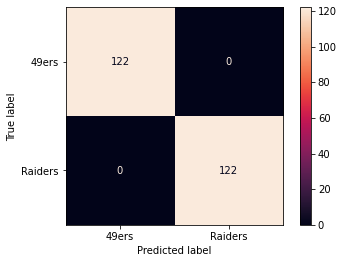

In [133]:
confusion_mat(lsvc_grid, Z_test, y_test, 'rocket');


And again we got 100%

### Maybe this was too easy...

Let's try this again but make it a little more challenging for our model by removing some of the most commonly used player names of each team.

Let's start by pulling the team-specific words/names into the new_words list to put into stop-words.

In [134]:
# Using the function we created to pull the top 30 words for each separate df
top_30_niners = top_words_niners(30)
top_30_niners = pd.DataFrame(top_30_niners)
top_30_niners

,0
game,11.731147
jimmy,10.900527
go,7.598819
packers,7.429023
time,7.297862
vs,7.243337
shanahan,7.028759
week,6.695477
trey,6.574664
play,6.507333


In [135]:
# We'll put the top words that we know are specific to each team into our new stop-words

for word in top_30_niners.index:
    if word in ['jimmy', 'packers', 'shanahan',
                'trey', 'lance', 'garoppolo', 'kyle',
                'kittle', 'lombardi', 'seahawks']:
        new_words.append(word)

In [136]:
# same for our second subreddit

top_30_raiders = top_words_raiders(30)
top_30_raiders = pd.DataFrame(top_30_raiders)
top_30_raiders

,0
game,11.188269
week,9.173907
chargers,8.567736
nfl,7.544060
renfrow,7.113467
monday,6.844823
win,6.549135
carr,6.528604
one,5.676373
vs,5.392578


In [137]:
for word in top_30_raiders.index:
    if word in ['chargers', 'renfrow', 'carr',
                'derek', 'gruden', 'hunter']:
        new_words.append(word)

In [138]:
# resintantiating X and y on our original combined df without any polynomials
X = df['title_comment']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

In [139]:
model_params = model_params
count = count

# rerunning the first model but with our updated stop words

pipe2 = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

params = {
    'tfid__max_df': [0.88, .98],
    'tfid__min_df': [.05, 0.1],
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__ngram_range': [(1,1), (1,2)],
    'tfid__stop_words': [new_words],
    'mnb__alpha': [0.1, 0.2]
}
mnb_grid2 = GridSearchCV(pipe2,
                        param_grid=params,
                        cv=3,
                        verbose=1)

mnb_grid2.fit(X_train, y_train)


count += 1

mnb_grid2.best_params_['score'] = mnb_grid2.best_score_
mnb_grid2.best_params_['estimator'] = mnb_grid2.estimator
model_params[f'model_{count}'] = mnb_grid2.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    5.3s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,min_samples_leaf,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha,C,max_iter
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_7,0.1,0.88,2000.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.521858,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,5.0,3000.0,0.4,18.0,NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,2.0,NaN,0.4,10.0,NaN,NaN,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,NaN,3.0,NaN,NaN,NaN,10.0,0.1,NaN,NaN
model_6,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,LinearSVC(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,5000.0


In [140]:
# our new model scores on training and testing
print(mnb_grid2.score(X_train, y_train))
print(mnb_grid2.score(X_test, y_test))

0.5532786885245902
0.5491803278688525


In [141]:
comp = model_comparison(mnb_grid2, X_train, X_test)

Our scores aren't very different but they are a bit lower after removing those words, especially our training score.

In [142]:
# TFID Vectorizing the 'title' column with updated stop-words
tfid5 = TfidfVectorizer(stop_words=new_words)
tfid5.fit(X)
X_2 = tfid5.transform(X)
print(X_2.shape)

(976, 4538)


In [143]:
X_df2 = pd.DataFrame(X_2.todense(), 
                          columns=tfid5.get_feature_names())
X_df2.head()

,00,000,02,03,035fe35f019,04,05,07,09,10,...,ypc,yrds,ysk,yt,zach,zachariason,zay,zero,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
X = X_df2
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

In [145]:
model_params = model_params
count=count

dt2 = DecisionTreeClassifier()

params = {
    'max_depth': [None, 5, 6],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [3, 4, 5],
    'max_features': [2000, 3000]}

dt_grid2 = GridSearchCV(dt2,
                       param_grid=params,
                       cv=5,
                       verbose=1)

# Fit model
dt_grid2.fit(X_train, y_train)

count += 1
dt_grid2.best_params_['score'] = dt_grid2.best_score_
dt_grid2.best_params_['estimator'] = dt_grid2.estimator
model_params[f'model_{count}'] = dt_grid2.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   30.9s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,min_samples_leaf,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha,C,max_iter
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_7,0.1,0.88,2000.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.521858,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,5.0,3000.0,0.4,18.0,NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,2.0,NaN,0.4,10.0,NaN,NaN,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,NaN,3.0,NaN,NaN,NaN,10.0,0.1,NaN,NaN
model_6,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,LinearSVC(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,5000.0
model_8,NaN,NaN,NaN,NaN,NaN,NaN,0.613419,DecisionTreeClassifier(),NaN,3000.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
print(dt_grid2.score(X_train, y_train))
print(dt_grid2.score(X_test, y_test))

0.8579234972677595
0.6598360655737705


In [147]:
comp = model_comparison(dt_grid2, X_train, X_test)

Accuracy Score: 0.6598360655737705
Specificity Score: 0.7786885245901639
Sensitivity Score: 0.5409836065573771
Precision Score: 0.7096774193548387


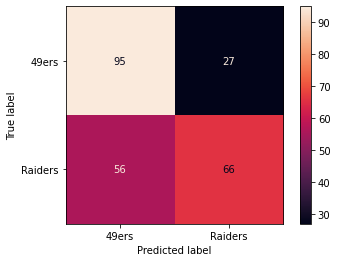

In [148]:
confusion_mat(dt_grid2, X_test, y_test, 'rocket');

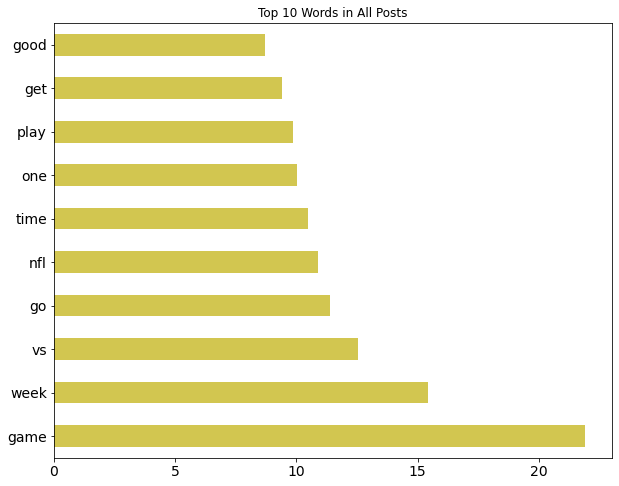

In [149]:
# Visual of top ten words across posts with new stop-words
plt.figure(figsize=(10,8))
top_10=X_df2.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='#D2C650',
                                                                 title = 'Top 10 Words in All Posts',
                                                                 )
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('charts/subreddit_top_words_2.png', bbox_inches='tight');

In [150]:
# repeating our previous steps for our new dfs
df_x2 = df.drop(columns=['title_comment', 'id', 'created_utc'])
X_df2 = X_df2.drop(columns=['subreddit'])
df_x2.reset_index(drop=True, inplace=True)
X_df2.reset_index(drop=True, inplace=True)

In [151]:
# concatening vectorized columns with columns we'll use as features from our original df
new_df2 = pd.concat([df_x2, X_df2], axis=1)
new_df2.head()

,subreddit,title_sent_count,comment_sent_count,title_word_count,comment_word_count,sent_count,word_count,sentim_val_compounds,00,000,...,ypc,yrds,ysk,yt,zach,zachariason,zay,zero,zip,zone
0,1,1,4,9,30,5,39,0.8496,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,0,69,0,5,69,0.1513,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,4,0,52,0,4,52,-0.7269,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,3,13,93,4,106,0.6197,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,43,8,955,44,963,0.9864,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
# checking for missing values
new_df2.isna().sum()[:10]

subreddit               0
title_sent_count        0
comment_sent_count      0
title_word_count        0
comment_word_count      0
sent_count              0
word_count              0
sentim_val_compounds    0
00                      0
000                     0
dtype: int64

In [153]:
# replacing any NaN with 0s
new_df2.replace(np.nan, 0, inplace=True)

In [203]:
# Creating a df of top positive and negative correlations with 'subreddit' (our target)

subreddit_corr2 = new_df2.corr()['subreddit']

subreddit_word_corr2 = {}
for index, corr in subreddit_corr2.items():
    if corr > 0.09 or corr < -0.08:
        subreddit_word_corr2[index] = corr
        
subreddit_word_corr2 = pd.DataFrame(subreddit_word_corr2.items(), columns=['Id', 'corr']).set_index('Id')
subreddit_word_corr2.sort_values(by='corr', ascending=False)

,corr
Id,
subreddit,1.000000
title_word_count,0.278660
title_sent_count,0.148572
calf,0.126067
george,0.114911
williams,0.110902
sf,0.106732
sherman,0.105999
norman,0.103130


In [155]:
# dropping 'subreddit' as we know it's 100% correlated with itself
subreddit_word_corr2.drop(index='subreddit', inplace=True)

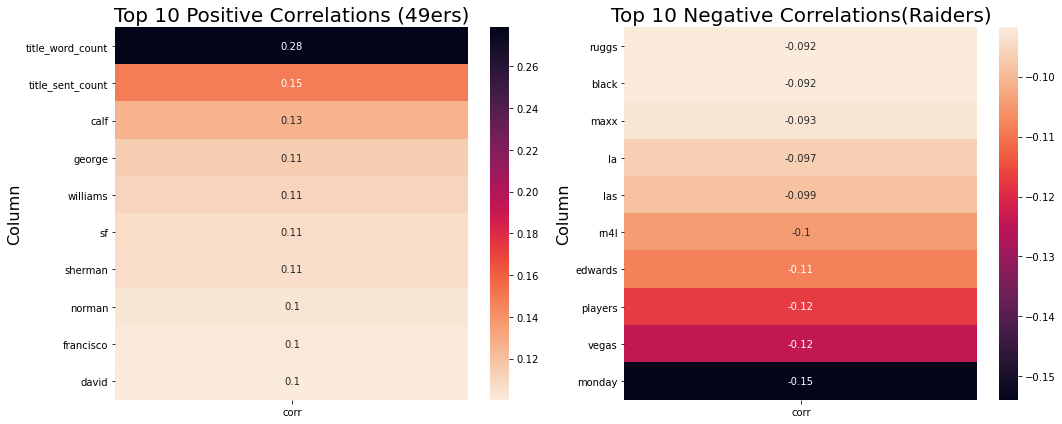

In [156]:
# Heatmap of top 10 positive and top 10 negative correlations with 'subreddit' (target)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax = plt.subplot(1, 2, 1)
ax = sns.heatmap(data=subreddit_word_corr2.sort_values(by='corr', ascending=False)[:10],
                 annot=True,
                 cmap='rocket_r')
ax.set_title('Top 10 Positive Correlations (49ers)', size=20)
ax.set_ylabel('Column', size=16)
ax2 = plt.subplot(1, 2, 2)
ax2 = sns.heatmap(data=subreddit_word_corr2.sort_values(by='corr', ascending=False)[-10:],
                  annot=True,
                  cmap='rocket')
ax2.set_title('Top 10 Negative Correlations(Raiders)', size=20)
ax2.set_ylabel('Column', size=16)
fig.tight_layout()
plt.savefig('charts/subreddit_corr_2.png', bbox_inches='tight');

In [205]:
# index for features
subreddit_word_corr2.index

Index(['subreddit', 'title_sent_count', 'title_word_count',
       'sentim_val_compounds', 'afc', 'almost', 'attack', 'bay', 'black',
       'calf', 'cb', 'chiefs', 'crosby', 'david', 'dc', 'deebo', 'dolphins',
       'edwards', 'francisco', 'george', 'green', 'hobbs', 'la', 'las', 'levi',
       'loss', 'love', 'maxx', 'miami', 'monday', 'nfl', 'norman', 'play',
       'players', 'plays', 'presser', 'rn4l', 'rodgers', 'ruggs', 'sf',
       'sherman', 'snf', 'vegas', 'waller', 'williams'],
      dtype='object', name='Id')

In [206]:
# reinstantiating X and y, train, test, split, and scaling data
features2 = list(subreddit_word_corr2.index)
X = new_df2[features2]
y = new_df2['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test  = sc.transform(X_test)

In [159]:
# double checking there's no missing values
new_df2.isna().sum().mean()

0.0

In [160]:
model_params = model_params
count = count

# rerunning model on new X and y with updated stop-words

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

ada_params = {
    'n_estimators': [15, 18],
    'learning_rate': [0.4, 0.5],
    'base_estimator__max_depth': [None, 5, 6],
#     'base_estimator__min_samples_split': [3, 4],
#     'base_estimator__min_samples_leaf': [3, 4],
#     'base_estimator__max_features': [2000, 3000]
}

ada_dt_grid2 = GridSearchCV(ada,
                      param_grid=ada_params,
                      cv=5,
                      verbose=1)

ada_dt_grid2.fit(Z_train, y_train)

count += 1

ada_dt_grid2.best_params_['score'] = ada_dt_grid2.best_score_
ada_dt_grid2.best_params_['estimator'] = ada_dt_grid2.estimator
model_params[f'model_{count}'] = ada_dt_grid2.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.2s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,min_samples_leaf,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha,C,max_iter
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_7,0.1,0.88,2000.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.521858,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,5.0,3000.0,0.4,18.0,NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,2.0,NaN,0.4,10.0,NaN,NaN,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,NaN,3.0,NaN,NaN,NaN,10.0,0.1,NaN,NaN
model_6,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,LinearSVC(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,5000.0
model_8,NaN,NaN,NaN,NaN,NaN,NaN,0.613419,DecisionTreeClassifier(),NaN,3000.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_9,NaN,NaN,NaN,NaN,NaN,NaN,0.654562,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,NaN,NaN,5.0,NaN,0.4,15.0,NaN,NaN,NaN


In [161]:
ada_dt_grid2.best_params_

{'base_estimator__max_depth': 5,
 'learning_rate': 0.4,
 'n_estimators': 15,
 'score': 0.6545615506476563,
 'estimator': AdaBoostClassifier(base_estimator=DecisionTreeClassifier())}

In [162]:
ada_dt_grid2.best_score_

0.6545615506476563

In [163]:
print (ada_dt_grid2.score(Z_train, y_train))
print (ada_dt_grid2.score(Z_test, y_test))

0.7431693989071039
0.5901639344262295


In [164]:
comp = model_comparison(ada_dt_grid2, Z_train, Z_test)

We can see it raised the score somewhat significantly, but has a wide variance. For good measure, we'll check another model.

In [165]:
features2 = list(subreddit_word_corr2.index)
X = new_df2[features2]
y = new_df2['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test  = sc.transform(X_test)

In [166]:
model_params = model_params
count = count

# rerunning LinearSVC with updated stop-word X and y

ada2 = AdaBoostClassifier(base_estimator=LinearSVC(max_iter=5000))

ada_params2 = {
    'n_estimators': [6, 7, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'algorithm': ['SAMME'],
    'base_estimator__C': np.linspace(0.01, 0.1, 10)
}

ada_grid2 = GridSearchCV(ada2,
                      param_grid=ada_params2,
                      cv=5,
                      verbose=1)

ada_grid2.fit(Z_train, y_train)

count += 1

ada_grid2.best_params_['score'] = ada_grid2.best_score_
ada_grid2.best_params_['estimator'] = ada_grid2.estimator
model_params[f'model_{count}'] = ada_grid2.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    7.2s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,...,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha,C,max_iter,algorithm,base_estimator__C
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_7,0.1,0.88,2000.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.521858,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,5.0,3000.0,0.40,18.0,NaN,NaN,NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,2.0,NaN,0.40,10.0,NaN,NaN,NaN,NaN,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,...,3.0,NaN,NaN,NaN,10.0,0.1,NaN,NaN,NaN,NaN
model_6,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,LinearSVC(),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.01,5000.0,NaN,NaN
model_8,NaN,NaN,NaN,NaN,NaN,NaN,0.613419,DecisionTreeClassifier(),NaN,3000.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_9,NaN,NaN,NaN,NaN,NaN,NaN,0.654562,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,5.0,NaN,0.40,15.0,NaN,NaN,NaN,NaN,NaN
model_10,NaN,NaN,NaN,NaN,NaN,NaN,0.651747,AdaBoostClassifier(base_estimator=LinearSVC(max_iter=5000)),NaN,NaN,...,NaN,NaN,NaN,0.15,8.0,NaN,NaN,NaN,SAMME,0.09


In [167]:
ada_grid2.best_params_

{'algorithm': 'SAMME',
 'base_estimator__C': 0.09000000000000001,
 'learning_rate': 0.15,
 'n_estimators': 8,
 'score': 0.6517472742521666,
 'estimator': AdaBoostClassifier(base_estimator=LinearSVC(max_iter=5000))}

In [168]:
ada_grid2.best_score_

0.6517472742521666

In [169]:
print (ada_grid2.score(Z_train, y_train))
print (ada_grid2.score(Z_test, y_test))

0.6475409836065574
0.6762295081967213


In [170]:
comp = model_comparison(ada_grid2, Z_train, Z_test)

Looks like LinearSVC did a similar job but with much less variance (before we even get to adding polynomials). Let's also try it with only our engineered features from our EDA and preprocessing to see how much weight those features hold in our model.

In [171]:
X = new_df2[['title_sent_count', 'comment_sent_count', 'title_word_count',
       'comment_word_count', 'sentim_val_compounds']]
y = new_df2['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test  = sc.transform(X_test)

In [172]:
model_params = model_params
count = count

# Rerunning model with only engineered features EDA and preprocessing steps

ada3 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

ada_params3 = {
    'n_estimators': [100, 110],
    'learning_rate': [0.4, 0.5, 0.6],
    'base_estimator__max_depth': [2, 3]
}

ada_dt_grid3 = GridSearchCV(ada3,
                      param_grid=ada_params3,
                      cv=5,
                      verbose=1)

ada_dt_grid3.fit(Z_train, y_train)

count += 1

ada_dt_grid3.best_params_['score'] = ada_dt_grid3.best_score_
ada_dt_grid3.best_params_['estimator'] = ada_dt_grid3.estimator
model_params[f'model_{count}'] = ada_dt_grid3.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   10.4s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,...,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha,C,max_iter,algorithm,base_estimator__C
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_7,0.1,0.88,2000.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.521858,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,5.0,3000.0,0.40,18.0,NaN,NaN,NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,2.0,NaN,0.40,10.0,NaN,NaN,NaN,NaN,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,...,3.0,NaN,NaN,NaN,10.0,0.1,NaN,NaN,NaN,NaN
model_6,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,LinearSVC(),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.01,5000.0,NaN,NaN
model_8,NaN,NaN,NaN,NaN,NaN,NaN,0.613419,DecisionTreeClassifier(),NaN,3000.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_9,NaN,NaN,NaN,NaN,NaN,NaN,0.654562,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,5.0,NaN,0.40,15.0,NaN,NaN,NaN,NaN,NaN
model_10,NaN,NaN,NaN,NaN,NaN,NaN,0.651747,AdaBoostClassifier(base_estimator=LinearSVC(max_iter=5000)),NaN,NaN,...,NaN,NaN,NaN,0.15,8.0,NaN,NaN,NaN,SAMME,0.09


In [173]:
ada_dt_grid3.best_params_

{'base_estimator__max_depth': 2,
 'learning_rate': 0.4,
 'n_estimators': 100,
 'score': 0.6053210325225981,
 'estimator': AdaBoostClassifier(base_estimator=DecisionTreeClassifier())}

In [174]:
ada_dt_grid3.best_score_

0.6053210325225981

In [175]:
print (ada_dt_grid3.score(Z_train, y_train))
print (ada_dt_grid3.score(Z_test, y_test))

0.8114754098360656
0.6065573770491803


In [176]:
comp = model_comparison(ada_dt_grid3, Z_train, Z_test)

Interesting! Looks like our initial engineered features raise the baseline accuracy by about 10 percentage points.


Now let's try doing the correlation and polynomial features for this updated stop-word X and y to see if we can still get a high score.

In [207]:
features2 = list(subreddit_word_corr2.index)
X = new_df[features2]
y = new_df['subreddit']


poly2 = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly2 = poly2.fit_transform(X)

X_poly2 = pd.DataFrame(data=X_poly2, columns = poly2.get_feature_names(features2))
X_poly2['subreddit'] = y

In [211]:
subreddit_corr_poly2 = X_poly2.corr()['subreddit']

subreddit_word_corr_poly2 = {}
for index, corr in subreddit_corr_poly2.items():
    if corr > 0.1 or corr < -0.07:
        subreddit_word_corr_poly2[index] = corr
        
subreddit_word_corr_poly2 = pd.DataFrame(subreddit_word_corr_poly2.items(), columns=['Id', 'corr']).set_index('Id')
subreddit_word_corr_poly2.sort_values(by='corr', ascending=False)

,corr
Id,
subreddit,1.000000
subreddit title_sent_count,0.744542
subreddit title_word_count,0.608198
title_word_count,0.278660
title_sent_count title_word_count,0.197818
...,...
title_sent_count vegas,-0.120846
vegas,-0.124144
title_word_count monday,-0.135336


In [212]:
# dropping 'subreddit' as we know it's 100% correlated with itself
subreddit_word_corr_poly2.drop(index='subreddit', inplace=True)

In [213]:
subreddit_word_corr_poly2.index

Index(['title_sent_count', 'title_word_count', 'sentim_val_compounds', 'afc',
       'almost', 'attack', 'black', 'calf', 'chiefs', 'crosby',
       ...
       'sentim_val_compounds attack', 'sentim_val_compounds chiefs',
       'sentim_val_compounds hobbs', 'sentim_val_compounds la',
       'sentim_val_compounds love', 'sentim_val_compounds rn4l',
       'almost attack', 'almost rn4l', 'attack rn4l', 'las vegas'],
      dtype='object', name='Id', length=123)

In [214]:
features_poly2 = list(subreddit_word_corr_poly2.index)
X = X_poly2[features_poly2]
y = new_df2['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test  = sc.transform(X_test)

In [215]:
model_params = model_params
count = count

# rerunning our ADABoostClassifier with DecisionTreeClassifier with poly features on our updated stop-word X and y

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

ada_params = {
    'n_estimators': [10, 15],
    'learning_rate': [0.4, 0.5, 0.6],
    'base_estimator__max_depth': [None, 5]
}

ada_dt_grid4 = GridSearchCV(ada,
                      param_grid=ada_params,
                      cv=5,
                      verbose=1)

ada_dt_grid4.fit(X_train, y_train)

count += 1

ada_dt_grid4.best_params_['score'] = ada_dt_grid4.best_score_
ada_dt_grid4.best_params_['estimator'] = ada_dt_grid4.estimator
model_params[f'model_{count}'] = ada_dt_grid4.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.5s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,...,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha,C,max_iter,algorithm,base_estimator__C
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_7,0.1,0.88,2000.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.521858,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,5.0,3000.0,0.40,18.0,NaN,NaN,NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,2.0,NaN,0.40,10.0,NaN,NaN,NaN,NaN,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,...,3.0,NaN,NaN,NaN,10.0,0.1,NaN,NaN,NaN,NaN
model_6,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,LinearSVC(),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.01,5000.0,NaN,NaN
model_8,NaN,NaN,NaN,NaN,NaN,NaN,0.613419,DecisionTreeClassifier(),NaN,3000.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_9,NaN,NaN,NaN,NaN,NaN,NaN,0.654562,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,5.0,NaN,0.40,15.0,NaN,NaN,NaN,NaN,NaN
model_10,NaN,NaN,NaN,NaN,NaN,NaN,0.651747,AdaBoostClassifier(base_estimator=LinearSVC(max_iter=5000)),NaN,NaN,...,NaN,NaN,NaN,0.15,8.0,NaN,NaN,NaN,SAMME,0.09


In [216]:
comp = model_comparison(ada_dt_grid4, X_train, X_test)

Accuracy Score: 1.0
Specificity Score: 1.0
Sensitivity Score: 1.0
Precision Score: 1.0


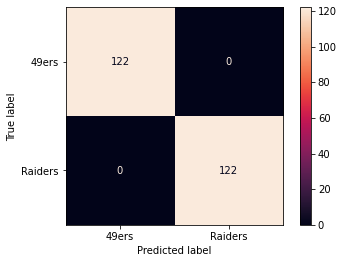

In [217]:
confusion_mat(ada_dt_grid4, X_test, y_test, 'rocket');

Last one!

In [218]:
features2 = list(subreddit_word_corr2.index)
X = new_df2[features2]
y = new_df2['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test  = sc.transform(X_test)

In [219]:
model_params = model_params
count = count

# rerunning LinearSVC with updated stop-word X and y

ada3 = AdaBoostClassifier(base_estimator=LinearSVC(max_iter=5000))

ada_params3 = {
    'n_estimators': [6, 7, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'algorithm': ['SAMME'],
    'base_estimator__C': np.linspace(0.01, 0.1, 10)
}

ada_grid3 = GridSearchCV(ada3,
                      param_grid=ada_params3,
                      cv=5,
                      verbose=1)

ada_grid3.fit(Z_train, y_train)

count += 1

ada_grid3.best_params_['score'] = ada_grid3.best_score_
ada_grid3.best_params_['estimator'] = ada_grid3.estimator
model_params[f'model_{count}'] = ada_grid3.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    3.1s finished


,mnb__alpha,tfid__max_df,tfid__max_features,tfid__min_df,tfid__ngram_range,tfid__stop_words,score,estimator,max_depth,max_features,...,min_samples_split,base_estimator__max_depth,base_estimator__max_features,learning_rate,n_estimators,ccp_alpha,C,max_iter,algorithm,base_estimator__C
model_1,0.1,0.83,1500.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.569672,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_7,0.1,0.88,2000.0,0.05,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, h...",0.521858,"(TfidfVectorizer(), MultinomialNB())",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,NaN,NaN,NaN,NaN,NaN,NaN,0.730901,DecisionTreeClassifier(),NaN,3000.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,NaN,NaN,0.741767,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,5.0,3000.0,0.40,18.0,NaN,NaN,NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,2.0,NaN,0.40,10.0,NaN,NaN,NaN,NaN,NaN
model_5,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,RandomForestClassifier(),3.0,NaN,...,3.0,NaN,NaN,NaN,10.0,0.1,NaN,NaN,NaN,NaN
model_6,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,LinearSVC(),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.01,5000.0,NaN,NaN
model_8,NaN,NaN,NaN,NaN,NaN,NaN,0.613419,DecisionTreeClassifier(),NaN,3000.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_9,NaN,NaN,NaN,NaN,NaN,NaN,0.654562,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),NaN,NaN,...,NaN,5.0,NaN,0.40,15.0,NaN,NaN,NaN,NaN,NaN
model_10,NaN,NaN,NaN,NaN,NaN,NaN,0.651747,AdaBoostClassifier(base_estimator=LinearSVC(max_iter=5000)),NaN,NaN,...,NaN,NaN,NaN,0.15,8.0,NaN,NaN,NaN,SAMME,0.09


In [220]:
comp = model_comparison(ada_grid3, Z_train, Z_test)

### Evaluation and Conceptual Understanding

Does the student accurately identify and explain the baseline score?
Does the student select and use metrics relevant to the problem objective?
Does the student interpret the results of their model for purposes of inference?
Is domain knowledge demonstrated when interpreting results?
Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?

Compared to our baseline score 50% or 0.5, our base model performed pretty well with only some data cleaning, and our fine tuned model did much better after more data cleaning, and using feature engineering.

In [221]:
# Our first model df pulls in the data out of order so we will reindex 
# and pull the estimators into our cleaner comp df since we don't like the estimators puled into that one
comp = comp.reindex([0, 6, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13])

In [222]:
comp['best_estimator'] = [i for i in model_df['estimator']]

In [223]:
comp = comp.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [230]:
comp

,model #,best_estimator,X_train_score,X_test_score,best_score
0,model1,"(TfidfVectorizer(), MultinomialNB())",0.602459,0.569672,0.569672
1,model2,DecisionTreeClassifier(),0.915301,0.713115,0.730901
2,model3,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),0.915301,0.721311,0.741767
3,model4,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),1.0,1.0,1.0
4,model5,RandomForestClassifier(),1.0,1.0,1.0
5,model6,LinearSVC(),1.0,1.0,1.0
6,model7,"(TfidfVectorizer(), MultinomialNB())",0.553279,0.54918,0.521858
7,model8,DecisionTreeClassifier(),0.857923,0.659836,0.613419
8,model9,AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),0.743169,0.590164,0.654562
9,model10,AdaBoostClassifier(base_estimator=LinearSVC(max_iter=5000)),0.647541,0.67623,0.651747


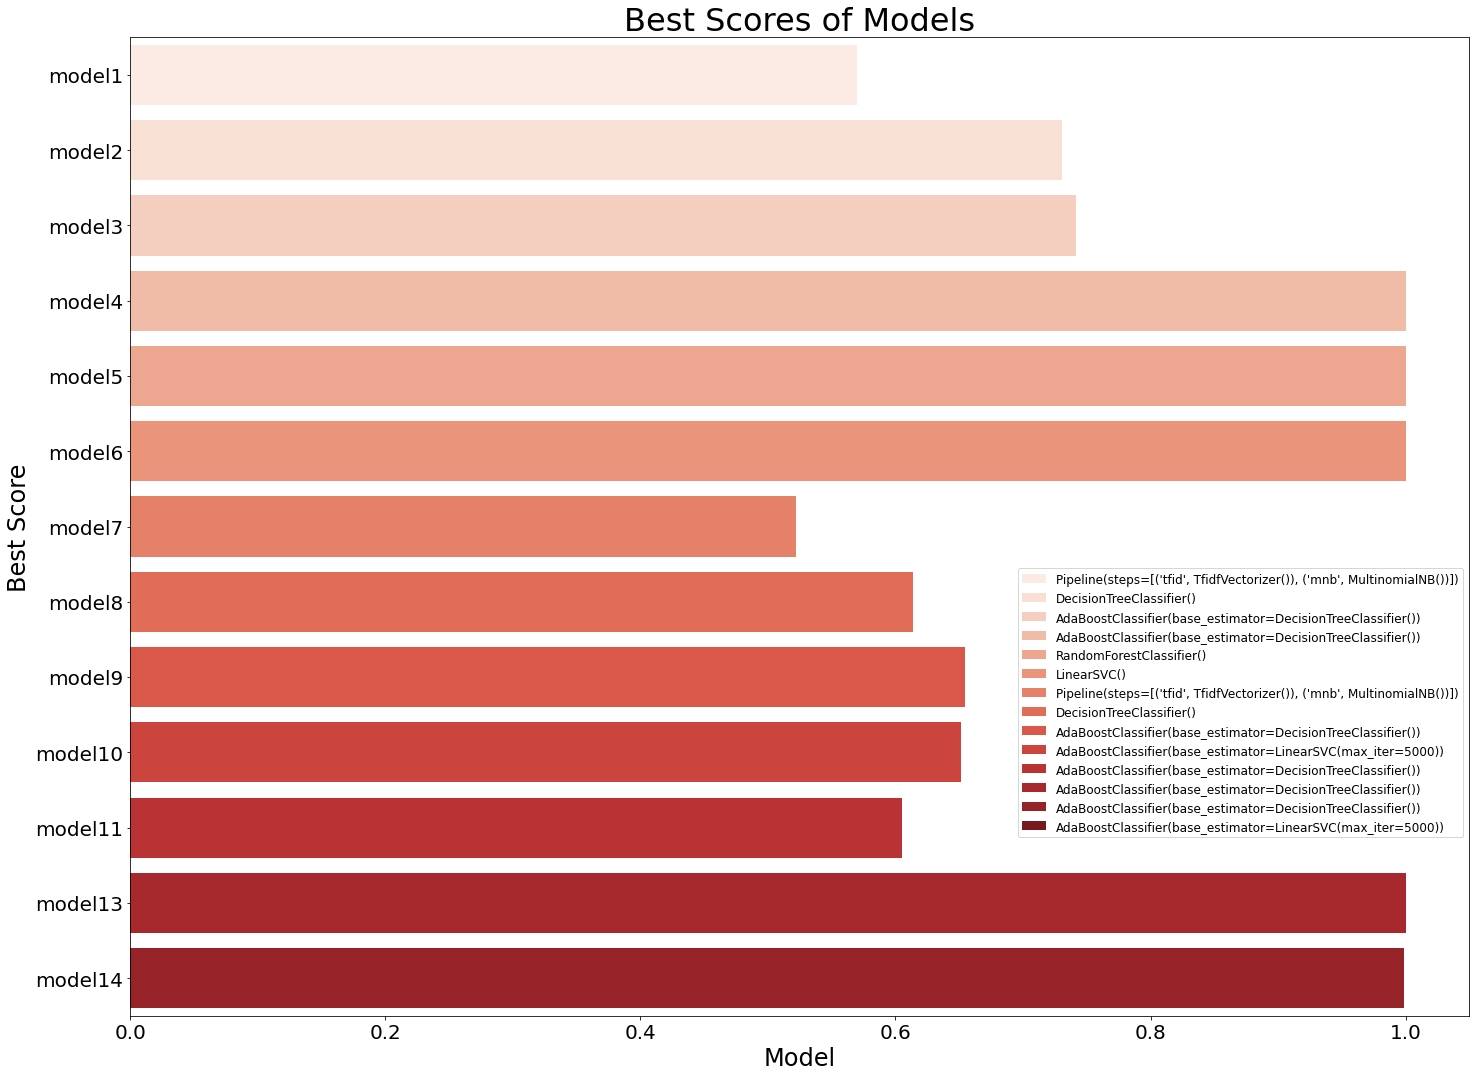

In [228]:
# plotting model scores with estimators in a legend
plt.figure(figsize=(24,18))
sns.barplot(data=comp, 
            x=comp['best_score'], 
            y=comp['model #'], hue=comp['best_estimator'],
            orient='h', palette='Reds', dodge=False)
plt.title('Best Scores of Models', size=32)
plt.xlabel('Model', size=24)
plt.ylabel('Best Score', size=24)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc=7, bbox_to_anchor=(1.0, 0.32), fontsize='large')
plt.savefig('charts/subreddits_models_bestscores.png', bbox_inches='tight');


|model #|best_estimator|X_train_score|X_test_score|best_score|feature diff|
|--------|-------------|-------------|------------|----------|------------|
|model1	|TfidfVectorizer(), MultinomialNB()|0.673497|0.639344|0.595628|only TFID on posts|
|model2	|DecisionTreeClassifier()|0.91|0.71|0.73|only TFID on posts|
|model3	|AdaBoostClassifier(base_estimator=DecisionTreeClassifier())|1.0|1.0|1.0|corr + poly/corr|
|model4	|RandomForestClassifier()| 1.0|1.0|1.0 | corr + poly/corr|
|model5	|AdaBoostClassifier(base_estimator=LinearSVC())| 1.0|1.0|1.0|corr + poly/corr|
|model6	|(TfidfVectorizer(), MultinomialNB())| 0.55| 0.54|0.52|more stop words|
|model7	|DecisionTreeClassifier()| 0.85|0.65 |0.61| more stop words|
|model8	|AdaBoostClassifier(base_estimator=DecisionTreeClassifier())|0.871585|0.647541|0.649054|more stop words + corr|
|model9|AdaBoostClassifier(base_estimator=LinearSVC())|0.655738|0.684426|0.646286|more stop words + corr|
|model10|AdaBoostClassifier(base_estimator=DecisionTreeClassifier())|0.819672|0.606557|0.605302|only engineered features|
|model11|AdaBoostClassifier(base_estimator=DecisionTreeClassifier())|1.0|1.0|1.0|more stop words + corr + poly/corr|
|model12|AdaBoostClassifier(base_estimator=LinearSVC())|1.0|0.98|0.99|more stop words + corr + poly/corr|



The above is a data dictionary of our final models and their relative (may have slight variation due to rerunning cells) outputs. The 'feature diff' column is a brief explanation of the differences in the features from one model to another. Some were ran with the same features to see if there would be a difference in their scores. 

- Our first model, the Multinomial Naïve Bayes had a fairly low accuracy as we only used the vectorized text column as features using a pipeline and grid. Keep in mind that the text was preprocessed before being vectorized.
- The second model, the DecisionTreeClassifier did quite a bit better once the params were adjusted and max depth was 5. The accuracy score was still not good enough, so we adjusted some features.
- Before running our third model, we used the most highly correlated words with the target 'subreddit' and then turned those columns into polynomials and used the most highly correlated of the new df with polynomials as features for our next 3 models.
- Our next 3 models all scored 100% or very close to!
- Considering this felt too easy, we decided to rerun our models but remove some of our top common words that are specifically team related. We added those words into our 'stop-words' parameter and reran the TFID vectorizer.
- For our sixth model, we ran the same exact model as our first but with our updated list of stop-words in our vectorizer. The score was a little lower as expected.
- We ran the exact same DecisionTreeClassifier model as our second model but with the new stop-words and again had lower accuracy scores as expected.
- For our next model, we used only the highly correlated words from our features as new features, and used an ADA Boost Classifier with our Decision Trees, and got a slight boost in our model's scores.
- We tried the same features and ADA boost Classifier but with a Linear SVC Model and got a very slight improvement in the accuracy scores.
- We wanted to see how much our engineered features (besides any text data/words) of word lengths and sentiment scores affected our model, so we ran a model with only those features and no words. The accuracy scores were unsurprisingly lower but surprisingly about 60% which tells us that they raise the accuracy by about 10 percentage points from our baseline of 50%.
- Finally we wanted to see if using the polynomial features would again boost our accuracy to the max, so we reran the correlation on polynomial features and used only the highest correlated features with the ADA boost Classifier with base estimator Decision Tree Classifier. We again got 100%, but we needed more features than our previous similar models to make up for the stop-words we removed.


### Final Model Chosen: 

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

With Polynomial Features that are highest correlated with the target. We found that we needed to have around 120-200 features to get to 100% accuracy.

### Conclusion and Recommendations


We created a model that can accurately predict between two subreddits.

We recommend testing on more data and different subreddits in the future.